In [2]:
# Import all needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load Data

In [3]:

#load loan dataset given in the loan.csv file
loan = pd.read_csv('loan.csv', low_memory=False)
print(loan.info())
loan.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB
None


id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  1077501    1296599       5000         5000           4975.0   36 months   
1  1077430    1314167       2500         2500           2500.0   60 months   
2  1077175    1313524       2400         2400           2400.0   36 months   
3  1076863    1277178      10000        10000          10000.0   36 months   
4  1075358    1311748       3000         3000           3000.0   60 months   

  int_rate  installment grade sub_grade  ... num_tl_90g_dpd_24m  \
0   10.65%       162.87     B        B2  ...                NaN   
1   15.27%        59.83     C        C4  ...                NaN   
2   15.96%        84.33     C        C5  ...                NaN   
3   13.49%       339.31     C        C1  ...                NaN   
4   12.69%        67.79     B        B5  ...                NaN   

  num_tl_op_past_12m pct_tl_nvr_dlq  percent_bc_gt_75 pub_rec_bankruptcies  \
0                NaN            NaN               NaN                  0.0   
1                NaN            NaN               NaN                  0.0   
2                NaN            NaN               NaN                  0.0   
3                NaN            NaN               NaN                  0.0   
4                NaN            NaN               NaN                  0.0   

  tax_liens tot_hi_cred_lim total_bal_ex_mort total_bc_limit  \
0       0.0             NaN               NaN            NaN   
1       0.0             NaN               NaN            NaN   
2       0.0             NaN               NaN            NaN   
3       0.0             NaN               NaN            NaN   
4       0.0             NaN               NaN            NaN   

  total_il_high_credit_limit  
0                        NaN  
1                        NaN  
2                        NaN  
3                        NaN  
4                        NaN  

[5 rows x 111 columns]

# 2. Inspecting Columns

### 2.1 Categorial Columns

In [4]:
#get categorical columns
categorical = loan.select_dtypes(include=['object'])
categorical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   term                 39717 non-null  object
 1   int_rate             39717 non-null  object
 2   grade                39717 non-null  object
 3   sub_grade            39717 non-null  object
 4   emp_title            37258 non-null  object
 5   emp_length           38642 non-null  object
 6   home_ownership       39717 non-null  object
 7   verification_status  39717 non-null  object
 8   issue_d              39717 non-null  object
 9   loan_status          39717 non-null  object
 10  pymnt_plan           39717 non-null  object
 11  url                  39717 non-null  object
 12  desc                 26775 non-null  object
 13  purpose              39717 non-null  object
 14  title                39706 non-null  object
 15  zip_code             39717 non-null  object
 16  addr

### 2.2 Numerical Columns

In [5]:
#get numerical columns
numerical = loan.select_dtypes(exclude=['object'])
numerical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 87 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              39717 non-null  int64  
 1   member_id                       39717 non-null  int64  
 2   loan_amnt                       39717 non-null  int64  
 3   funded_amnt                     39717 non-null  int64  
 4   funded_amnt_inv                 39717 non-null  float64
 5   installment                     39717 non-null  float64
 6   annual_inc                      39717 non-null  float64
 7   dti                             39717 non-null  float64
 8   delinq_2yrs                     39717 non-null  int64  
 9   inq_last_6mths                  39717 non-null  int64  
 10  mths_since_last_delinq          14035 non-null  float64
 11  mths_since_last_record          2786 non-null   float64
 12  open_acc                        

Looking at above results, it appears that some numerical, date type columns are present as object.

- int_rate, revol_util can be cleaned to remove "%" character and then convert it into float
- issue_d, earliest_cr_line, last_pymnt_d, next_pymnt_d, last_credit_pull_d sould be converted into date
- term should converted into number by removing "months" string literals from its value
- url column is not useful can be dropped
- drop member id and id columns since they are ids and has no business info

# 3. Data Cleaning

### 3.1 Clean Nulls

In [6]:
#check null values in dataset
loan.isna().sum()

id                                0
member_id                         0
loan_amnt                         0
funded_amnt                       0
funded_amnt_inv                   0
                              ...  
tax_liens                        39
tot_hi_cred_lim               39717
total_bal_ex_mort             39717
total_bc_limit                39717
total_il_high_credit_limit    39717
Length: 111, dtype: int64

In [7]:
# Drop columns having all values null
def removeColumnWithAllNullValue(dataframe):
    # List the column names which have all the values as null only
    nullValueColumnNames = dataframe.columns[(~dataframe.isnull()).sum() == 0]
    if len(nullValueColumnNames) == 0:
        print("No column found with all null value")
        return dataframe
    
    print(f"List of columns having all null values: \n {nullValueColumnNames}")
    # validate that these columns indeed have only null values.
    # Find count of columns among these columns which has any not null value. Assert that count of such column is zero
    assert ((~dataframe[nullValueColumnNames].isnull()).sum() > 0).sum() == 0, "Count of columns having all null values should be null."

    return dataframe.drop(nullValueColumnNames, axis=1)

# Drop empty rows
def removeRowsWithAllNullValue(dataframe):
    IsEmptyRowIndices = (~dataframe.isnull()).sum(axis=1) == 0
    emptyRowCount = IsEmptyRowIndices.sum()
    if (emptyRowCount == 0):
        print(f"No empty row found")
        return dataframe
    
    print(f"found {emptyRowCount} empty row(s)")  
    clearnedData = dataframe.drop(dataframe[IsEmptyRowIndices.index])
    assert ((~dataframe.isnull()).sum(axis=1) == 0).sum() == 0, "Count of rows with all values null should be zero"
    return clearnedData

# drop columns having single values
def dropMonotonousColumns(dataframe):
    singleValueColumns = dataframe.columns[dataframe.nunique() == 1]
    if (len(singleValueColumns) == 0):
        print("No column found having same value in all rows")
        return dataframe

    print(f"Columns with single value in all rows :{singleValueColumns}")
    return dataframe.drop(singleValueColumns, axis=1)

In [8]:
# in dataset, we can see around half of the columns are null, hence remove all columns having no values. Do the same for rows
loan = removeRowsWithAllNullValue(removeColumnWithAllNullValue(loan))

List of columns having all null values: 
 Index(['mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint',
       'verification_status_joint', 'tot_coll_amt', 'tot_cur_bal',
       'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m',
       'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m',
       'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi',
       'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal',
       'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
       'mths_since_recent_inq', 'mths_since_recent_revol_delinq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m',
       'num_tl_30dpd', 'num_tl_90g_dpd_24m', '

### 3.2 Clean Rows

##### 3.2.1 Removing records with loan status as “Current”, as the loan is currently running and we can’t infer any information regarding default from such loans.

In [9]:
# drop rows having value of loan_status as Current
rowsWithLoanStatusAsCurrent = loan[loan.loan_status == "Current"]
print(f"dropping {rowsWithLoanStatusAsCurrent.shape[0]} rows having loan status = Current");

loan = loan.drop(rowsWithLoanStatusAsCurrent.index)
assert (loan.loan_status == "Current").sum() == 0, "Loan status should not have value Current"

# since we removed some rows, lets check and remove all null column and rows
loan = removeRowsWithAllNullValue(removeColumnWithAllNullValue(loan))

dropping 1140 rows having loan status = Current


List of columns having all null values: 
 Index(['next_pymnt_d'], dtype='object')
No empty row found


##### 3.2.2 dropping rows corresponding to very low count dimensions

In [10]:
# look through the purpose value counts
loan_purpose_values = loan["purpose"].value_counts()*100/loan.shape[0]

# remove rows with less than 1% of value counts in paricular purpose 
loan_purpose_delete = loan_purpose_values[loan_purpose_values<1].index.values
loan = loan[[False if p in loan_purpose_delete else True for p in loan["purpose"]]]

### 3.3 Drop monotonous columns

In [11]:
# drop monotonous values columns
loan = dropMonotonousColumns(loan)

# Since we removed some columns lets check for empty rows again.
loan = removeRowsWithAllNullValue(loan)

Columns with single value in all rows :Index(['pymnt_plan', 'initial_list_status', 'out_prncp', 'out_prncp_inv',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt',
       'tax_liens'],
      dtype='object')
No empty row found


### 3.4 Drop non behavioral columns

In [12]:
# drop id, member_id, url column since it does not seems to have any useful info
loan = loan.drop(['url', 'member_id', 'id'], axis=1)

### 3.5 Handle missing values

In [13]:
# check null values in emp_length
loan["emp_length"].isna().value_counts(normalize=True)

emp_length
False    0.973883
True     0.026117
Name: proportion, dtype: float64

In [14]:
columnNameHavingNull = "emp_length"
PercentageDropOverall = loan[columnNameHavingNull].isna().value_counts(normalize=True).filter(items=[True])[0]
chargedOffCount = loan["loan_status"].value_counts().filter(items=["Charged Off"]).iloc[0]
chargedOffCountHavingNullRevolUtil = loan[loan[columnNameHavingNull].isna()]["loan_status"].value_counts().filter(items=["Charged Off"]).iloc[0]
print(f"{round(PercentageDropOverall)}% overll and {round(100*chargedOffCountHavingNullRevolUtil/chargedOffCount)}% on ChargedOff records are impacted by null {columnNameHavingNull}")

0% overll and 4% on ChargedOff records are impacted by null emp_length


C:\Users\rajranja\AppData\Local\Temp\ipykernel_31420\2793191488.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  PercentageDropOverall = loan[columnNameHavingNull].isna().value_counts(normalize=True).filter(items=[True])[0]


In [15]:
columnNameHavingNull = "revol_util"
PercentageDropOverall = loan[columnNameHavingNull].isna().value_counts(normalize=True).filter(items=[True])[0]
chargedOffCount = loan["loan_status"].value_counts().filter(items=["Charged Off"]).iloc[0]
chargedOffCountHavingNullRevolUtil = loan[loan[columnNameHavingNull].isna()]["loan_status"].value_counts().filter(items=["Charged Off"]).iloc[0]
print(f"{round(PercentageDropOverall,2)}% overll and {round(100*chargedOffCountHavingNullRevolUtil/chargedOffCount,2)}% on ChargedOff records are impacted by null {columnNameHavingNull}")

0.0% overll and 0.29% on ChargedOff records are impacted by null revol_util


C:\Users\rajranja\AppData\Local\Temp\ipykernel_31420\2170988437.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  PercentageDropOverall = loan[columnNameHavingNull].isna().value_counts(normalize=True).filter(items=[True])[0]


In [16]:
# Based on above impact analysis we can take a call to drop these rows since impact is very low.

# In 12 unique values we have 10+ years the most for emp_length, but it is highly dependent variable so we will not impute but remove the rows with null values.
loan.dropna(axis=0, subset=["emp_length"], inplace=True)

# Revolving line utilization rate is used  to measure how much of the available revolving credit ( i.e lines of credit, credit cards etc.) a user is currently using.
# It is indication of user's credit usage relative to their total available credit. This is important for both the borrowers and lenders.
loan.dropna(axis=0, subset=["revol_util"], inplace=True)

### 3.6 Standardization

In [17]:
def convertToDateTime(df, columnName):
    try:
        df[columnName] = pd.to_datetime(df[columnName], format='%b-%y')
    except Exception as e:
        print (e)
        df[columnName] = pd.to_datetime(df[columnName], format='%b-%Y')
    return df

In [18]:
# update int_rate, revol_util without % sign and as numeric type
loan["int_rate"] = loan["int_rate"].apply(lambda x:x if pd.isna(x) else float(x.replace("%", "")))

loan["revol_util"] = loan["revol_util"].apply(lambda x:x if pd.isna(x) else float(x.replace('%', "")))

In [19]:
#get term data
loan["term"].unique()

array([' 36 months', ' 60 months'], dtype=object)

In [20]:
# remove text data from term feature and store as numerical
loan["term"] = loan["term"].apply(lambda x:int(x.split()[0]))

In [21]:
# update emp_length feature with continuous values as int
# where (< 1 year) is assumed as 0 
# 10+ years is assumed as 10 
# rest are stored as their magnitude
loan["emp_length"] = pd.to_numeric(loan["emp_length"].apply(lambda x:x if pd.isna(x) else 0 if "<" in x else (x.split('+')[0] if "+" in x else x.split()[0])))

In [22]:
# convert issue_d into datetime
loan = convertToDateTime(loan, 'issue_d')
loan['issue_d'].describe()

count                            36388
mean     2010-10-26 01:35:46.070132992
min                2007-06-01 00:00:00
25%                2010-05-01 00:00:00
50%                2011-01-01 00:00:00
75%                2011-08-01 00:00:00
max                2011-12-01 00:00:00
Name: issue_d, dtype: object

In [23]:
# convert earliest_cr_line into datetime [special handling since year is in 2 digits and start from 1946, default parsing makes it 2046 instead of 1946.]
loan["earliest_cr_line"] = loan["earliest_cr_line"].apply(lambda x:x.split("-")[0] + "-" + ("19" if int(x.split("-")[1]) > 45 else "20") + x.split("-")[1])
loan = convertToDateTime(loan, "earliest_cr_line")
loan['earliest_cr_line'].describe()

unconverted data remains when parsing with format "%b-%y": "85", at position 0. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.


count                            36388
mean     1997-03-20 18:19:42.455754624
min                1946-01-01 00:00:00
25%                1994-01-01 00:00:00
50%                1998-06-01 00:00:00
75%                2001-09-01 00:00:00
max                2008-11-01 00:00:00
Name: earliest_cr_line, dtype: object

In [24]:
# convert last_pymnt_d into datetime
loan = convertToDateTime(loan, 'last_pymnt_d')
loan['last_pymnt_d'].describe()

count                            36331
mean     2013-03-10 03:35:03.757122048
min                2008-01-01 00:00:00
25%                2012-04-01 00:00:00
50%                2013-04-01 00:00:00
75%                2014-04-01 00:00:00
max                2016-05-01 00:00:00
Name: last_pymnt_d, dtype: object

In [25]:
# convert last_credit_pull_d into datetime
loan = convertToDateTime(loan, 'last_credit_pull_d')
loan['last_credit_pull_d'].describe()

count                            36386
mean     2014-08-26 05:32:40.380366336
min                2007-06-01 00:00:00
25%                2013-05-01 00:00:00
50%                2015-02-01 00:00:00
75%                2016-04-01 00:00:00
max                2016-05-01 00:00:00
Name: last_credit_pull_d, dtype: object

### 3.7 Outlier Treatment

In [26]:
def dropHigherQuantileRecords(df, columnName, quantileCutValue):
    condition = df[columnName].quantile(quantileCutValue)
    filterResult = df[columnName] < condition
    chargedOffCount = df["loan_status"][~filterResult].value_counts().filter(items=["Charged Off"])[0]
    print(f"{filterResult.value_counts().filter(items=[False])[0]} rows removed of which {chargedOffCount} belongs to Charged off")
    df = df[filterResult]
    return df

In [27]:
#describe borrower annual income
loan["annual_inc"].describe()

count    3.638800e+04
mean     6.954019e+04
std      6.495376e+04
min      4.080000e+03
25%      4.149600e+04
50%      6.000000e+04
75%      8.300000e+04
max      6.000000e+06
Name: annual_inc, dtype: float64

In [28]:
# for annual_inc, the highest value is 6000000 where 75% quantile value is 83000, and is 100 times the mean
# we need to remomve outliers from annual_inc i.e. 99 to 100%
loan = dropHigherQuantileRecords(loan, "annual_inc", 0.99)

364 rows removed of which 40 belongs to Charged off


C:\Users\rajranja\AppData\Local\Temp\ipykernel_31420\3797209712.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  chargedOffCount = df["loan_status"][~filterResult].value_counts().filter(items=["Charged Off"])[0]
C:\Users\rajranja\AppData\Local\Temp\ipykernel_31420\3797209712.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"{filterResult.value_counts().filter(items=[False])[0]} rows removed of which {chargedOffCount} belongs to Charged off")


In [29]:
#describe borrower's number of open credit lines in the borrower's credit file
loan["open_acc"].describe()

count    36024.000000
mean         9.305574
std          4.378094
min          2.000000
25%          6.000000
50%          9.000000
75%         12.000000
max         44.000000
Name: open_acc, dtype: float64

In [30]:
# for open_acc, the highest value is 44 where 75% quantile value is 12, and is 5 times the mean
# we need to remomve outliers from open_acc i.e. 99.9 to 100%
loan = dropHigherQuantileRecords(loan, "open_acc", 0.999)

41 rows removed of which 11 belongs to Charged off


C:\Users\rajranja\AppData\Local\Temp\ipykernel_31420\3797209712.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  chargedOffCount = df["loan_status"][~filterResult].value_counts().filter(items=["Charged Off"])[0]
C:\Users\rajranja\AppData\Local\Temp\ipykernel_31420\3797209712.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"{filterResult.value_counts().filter(items=[False])[0]} rows removed of which {chargedOffCount} belongs to Charged off")


In [31]:
#describe borrower's total number of credit lines currently in the borrower's credit file
loan["total_acc"].describe()

count    35983.000000
mean        22.030209
std         11.303195
min          2.000000
25%         14.000000
50%         20.000000
75%         29.000000
max         90.000000
Name: total_acc, dtype: float64

In [32]:
# for total_acc, the highest value is 90 where 75% quantile value is 29, and is 4 times the mean
# we need to remomve outliers from total_acc i.e. 98 to 100%
loan = dropHigherQuantileRecords(loan, "total_acc", 0.98)

778 rows removed of which 82 belongs to Charged off


C:\Users\rajranja\AppData\Local\Temp\ipykernel_31420\3797209712.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  chargedOffCount = df["loan_status"][~filterResult].value_counts().filter(items=["Charged Off"])[0]
C:\Users\rajranja\AppData\Local\Temp\ipykernel_31420\3797209712.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"{filterResult.value_counts().filter(items=[False])[0]} rows removed of which {chargedOffCount} belongs to Charged off")


# 4. Derive Variables

### 4.1 Month and Year extraction from Date

We can derive year and month from date type columns which can be used in analysis.
We can also represent loan_status column into is_defaulter indicating if the loan was defaulted or not.

In [33]:
# extracting month and year from issue_date
loan['issue_d_month'] = loan['issue_d'].apply(lambda x: x.month)
loan['issue_d_year'] = loan['issue_d'].apply(lambda x: x.year)

# get year from issue_d and replace the same
loan["earliest_cr_line_month"] = loan["earliest_cr_line"].apply(lambda x: x.month)
loan["earliest_cr_line_year"] = loan["earliest_cr_line"].apply(lambda x: x.year)

# Create new column as representation of update loan_status as Fully Paid to 0 and Charged Off to 1
loan["is_defaulter"] = loan["loan_status"].apply(lambda x: False if x == "Fully Paid" else True)


### 4.2 Binning Continuous data

In [34]:
# describe loan amount
loan["loan_amnt"].describe()

count    35205.000000
mean     11059.339582
std       7241.311046
min        500.000000
25%       5500.000000
50%       9950.000000
75%      15000.000000
max      35000.000000
Name: loan_amnt, dtype: float64

In [35]:
# create bins for loan_amnt range
bins = [0, 5000, 10000, 15000, 20000, 25000, 36000]
bucket_l = ['0-5000', '5000-10000', '10000-15000', '15000-20000', '20000-25000','25000+']
loan['loan_amnt_range'] = pd.cut(loan['loan_amnt'], bins, labels=bucket_l)

In [36]:
# describe interest rate
loan["int_rate"].describe()

count    35205.000000
mean        11.942805
std          3.664321
min          5.420000
25%          8.940000
50%         11.830000
75%         14.350000
max         24.110000
Name: int_rate, dtype: float64

In [37]:
# create bins for int_rate range
bins = [0, 7.5, 10, 12.5, 15, 100]
bucket_l = ['0-7.5', '7.5-10', '10-12.5', '12.5-15', '15+']
loan['int_rate_range'] = pd.cut(loan['int_rate'], bins, labels=bucket_l)
loan[['int_rate_range', 'int_rate']].head(10)

int_rate_range  int_rate
0         10-12.5     10.65
1             15+     15.27
2             15+     15.96
3         12.5-15     13.49
5          7.5-10      7.90
6             15+     15.96
7             15+     18.64
8             15+     21.28
9         12.5-15     12.69
10        12.5-15     14.65

In [38]:
loan['annual_inc'].describe()

count     35205.000000
mean      65448.008330
std       34735.384124
min        4080.000000
25%       40800.000000
50%       58000.000000
75%       80004.000000
max      234996.000000
Name: annual_inc, dtype: float64

In [39]:
# create bins for annual_inc range
bins = [0, 25000, 50000, 75000, 100000, 1000000]
bucket_l = ['0-25000', '25000-50000', '50000-75000', '75000-100000', '100000+']
loan['annual_inc_range'] = pd.cut(loan['annual_inc'], bins, labels=bucket_l)

In [40]:
loan['revol_util'].describe()

count    35205.000000
mean        49.295802
std         28.259722
min          0.000000
25%         26.100000
50%         49.800000
75%         72.800000
max         99.900000
Name: revol_util, dtype: float64

In [41]:
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
bin_labels = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
loan['revol_util_range'] = pd.cut(loan['revol_util'], bins, labels=bin_labels)
loan[['revol_util_range', 'revol_util']].head(10)

revol_util_range  revol_util
0                80        83.7
1                 0         9.4
2                90        98.5
3                20        21.0
5                20        28.3
6                80        85.6
7                80        87.5
8                30        32.6
9                30        36.5
10               20        20.6

In [42]:
loan['installment'].describe()

count    35205.000000
mean       322.784412
std        205.224460
min         15.690000
25%        167.840000
50%        279.890000
75%        424.850000
max       1305.190000
Name: installment, dtype: float64

In [43]:
# create bins for installment range
bins = [0, 200, 500, 800, 1500]
bins_label = ['low', 'medium', 'high', 'very high']
loan['installment_range'] = pd.cut(loan['installment'], bins, labels=bins_label)
loan[['installment_range', 'installment']].head(10)

installment_range  installment
0                low       162.87
1                low        59.83
2                low        84.33
3             medium       339.31
5                low       156.46
6                low       170.08
7                low       109.43
8                low       152.39
9                low       121.45
10               low       153.45

In [44]:
loan['dti'].describe()

count    35205.000000
mean        13.346125
std          6.631593
min          0.000000
25%          8.240000
50%         13.440000
75%         18.580000
max         29.990000
Name: dti, dtype: float64

In [45]:
# create bins for dti range
bins = [-1, 5.00, 10.00, 15.00, 20.00, 25.00, 50.00]
bucket_l = ['0-5%', '5-10%', '10-15%', '15-20%', '20-25%', '25%+']
loan['dti_range'] = pd.cut(loan['dti'], bins, labels=bucket_l)
loan[['dti_range','dti']].head(10)

dti_range    dti
0       25%+  27.65
1       0-5%   1.00
2      5-10%   8.72
3     15-20%  20.00
5     10-15%  11.20
6     20-25%  23.51
7      5-10%   5.35
8      5-10%   5.55
9     15-20%  18.08
10    15-20%  16.12

# 5. Univariate Analysis

In [46]:
# find current loan status ie. count of Current, Paid and Charged Off (defaulters). 
# Current are likely to be defaulters
loan["loan_status"].value_counts(normalize=True)

loan_status
Fully Paid     0.85593
Charged Off    0.14407
Name: proportion, dtype: float64

<Axes: xlabel='loan_status', ylabel='count'>

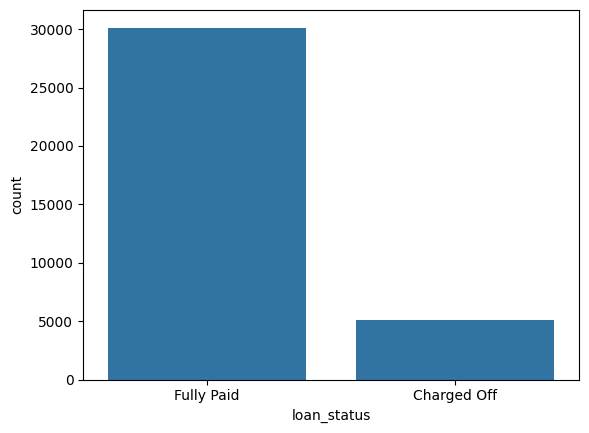

In [47]:
# check for amount of defaults in the data using countplot
sns.countplot(loan, x="loan_status")

From above plot we can see that ~14% of loans are defaulted.

<Axes: xlabel='annual_inc_range', ylabel='count'>

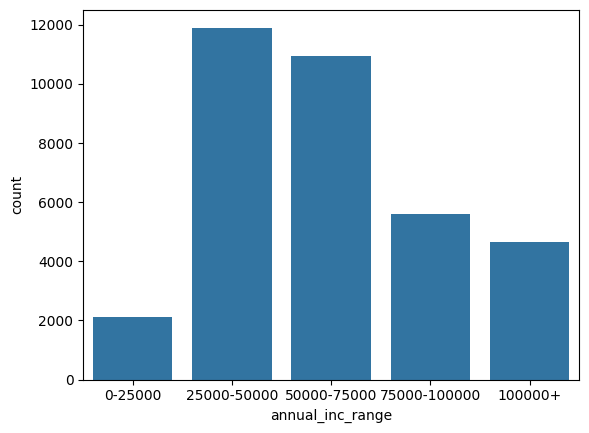

In [48]:
sns.countplot(loan, x="annual_inc_range")

<Axes: xlabel='issue_d_month', ylabel='count'>

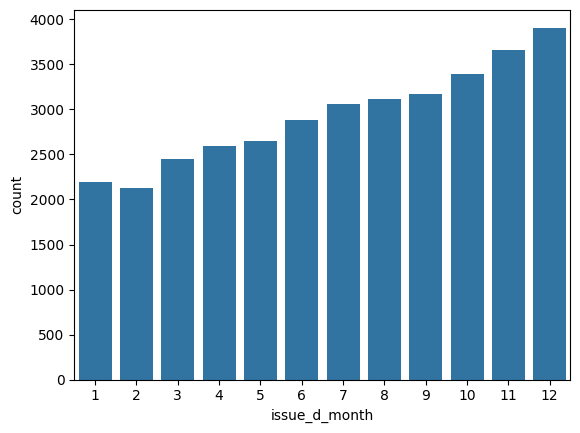

In [49]:
sns.countplot(loan, x="issue_d_month")

<Axes: xlabel='issue_d_year', ylabel='count'>

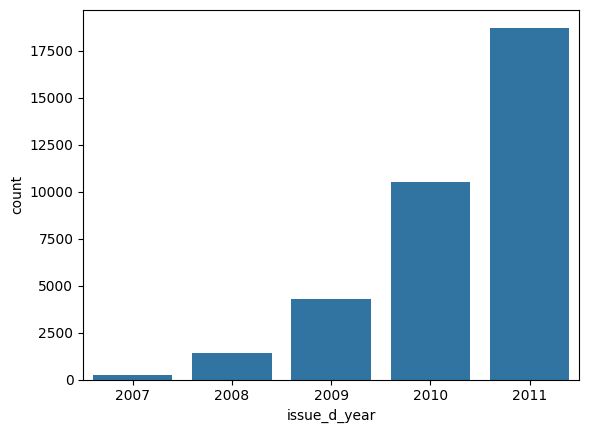

In [50]:
sns.countplot(loan, x="issue_d_year")

<Axes: xlabel='int_rate_range', ylabel='count'>

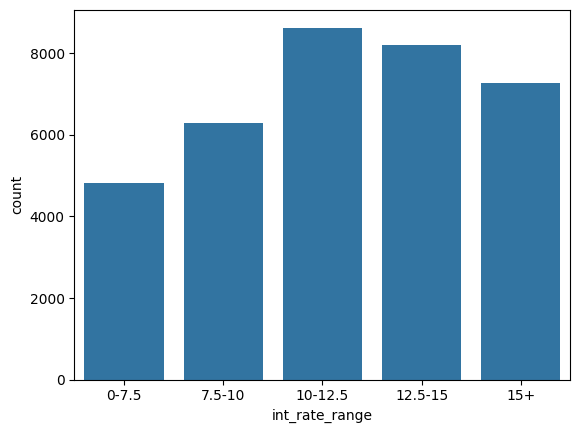

In [51]:
sns.countplot(loan, x="int_rate_range")

<Axes: xlabel='revol_util_range', ylabel='count'>

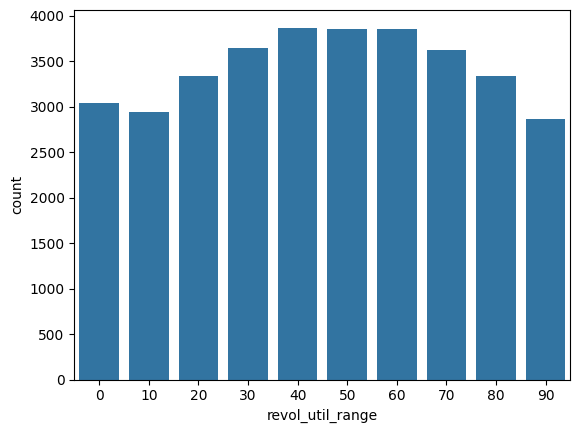

In [52]:
sns.countplot(loan, x="revol_util_range")

<Axes: xlabel='addr_state', ylabel='count'>

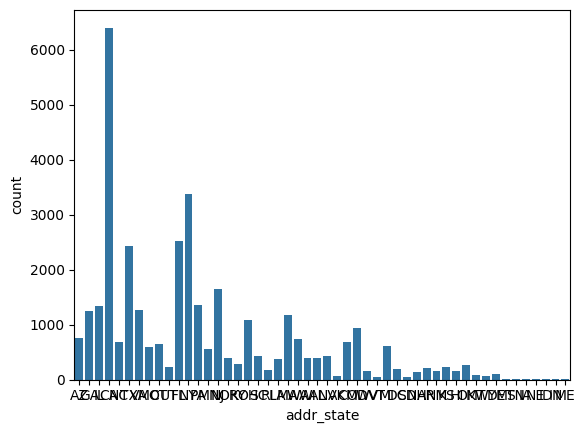

In [53]:
sns.countplot(loan, x="addr_state")

<Axes: xlabel='delinq_2yrs', ylabel='count'>

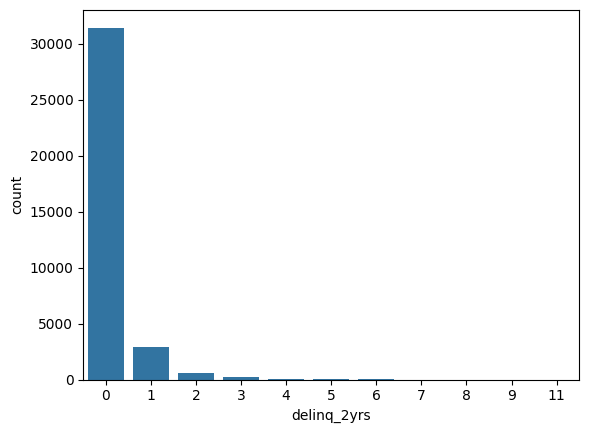

In [54]:
sns.countplot(loan, x="delinq_2yrs")


<Axes: xlabel='emp_length', ylabel='count'>

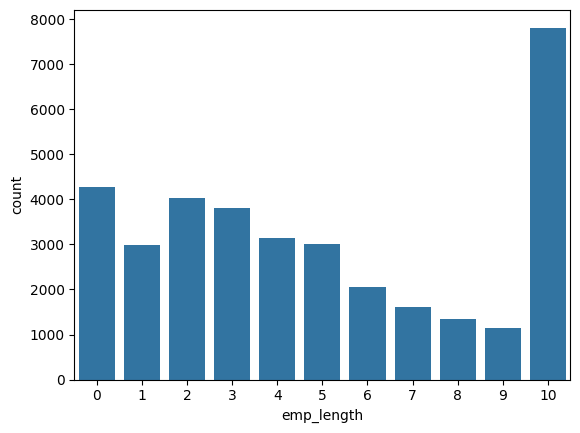

In [55]:
sns.countplot(loan, x="emp_length")


<Axes: xlabel='grade', ylabel='count'>

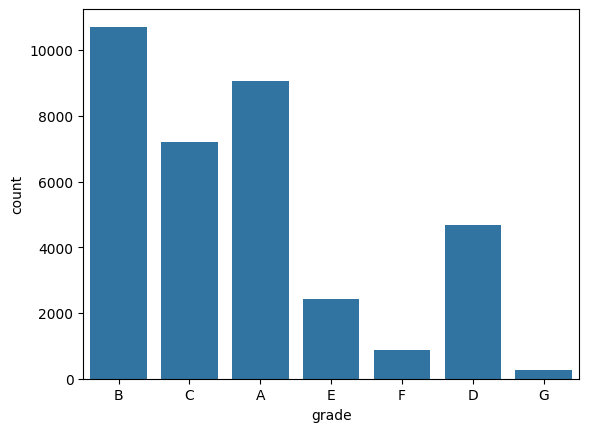

In [56]:
sns.countplot(loan, x="grade")

<Axes: xlabel='home_ownership', ylabel='count'>

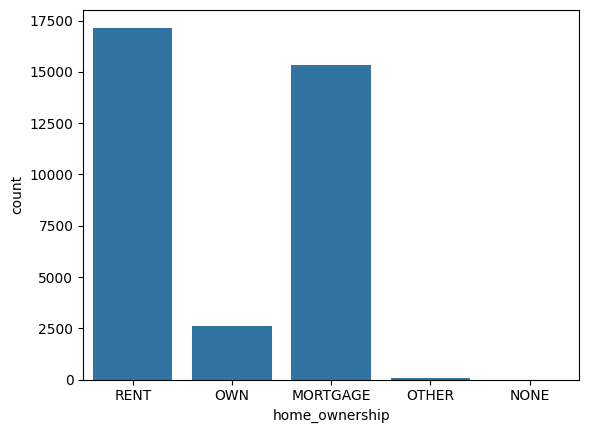

In [57]:
sns.countplot(loan, x="home_ownership")


<Axes: xlabel='total_acc', ylabel='count'>

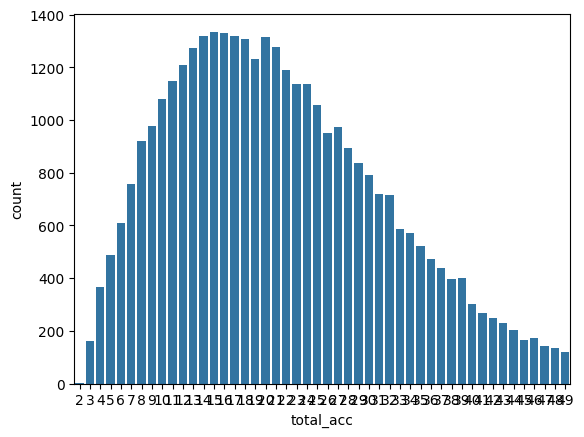

In [58]:
sns.countplot(loan, x="total_acc")

<Axes: xlabel='verification_status', ylabel='count'>

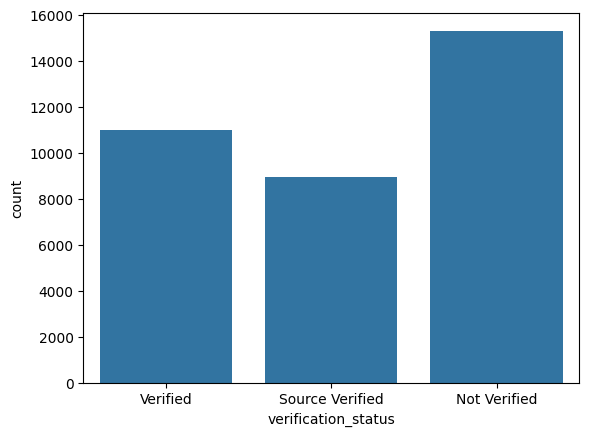

In [59]:
sns.countplot(loan, x="verification_status")

<Axes: xlabel='open_acc', ylabel='count'>

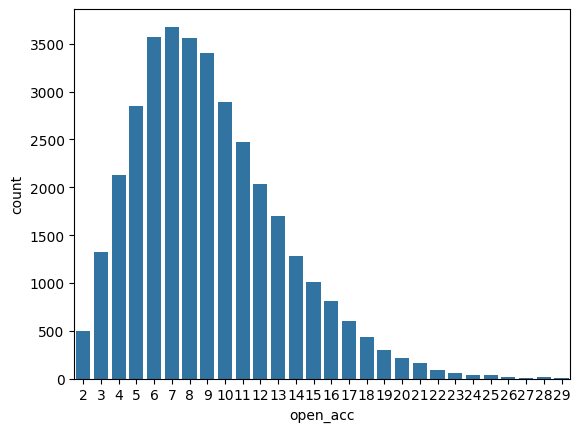

In [60]:
sns.countplot(loan, x="open_acc")

<Axes: xlabel='term', ylabel='count'>

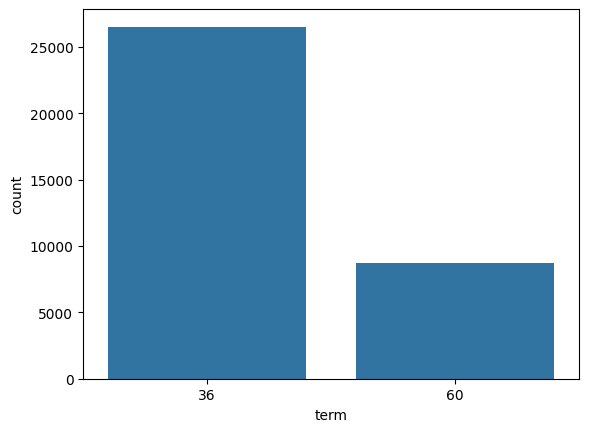

In [61]:
sns.countplot(loan, x="term")

<Axes: xlabel='purpose', ylabel='count'>

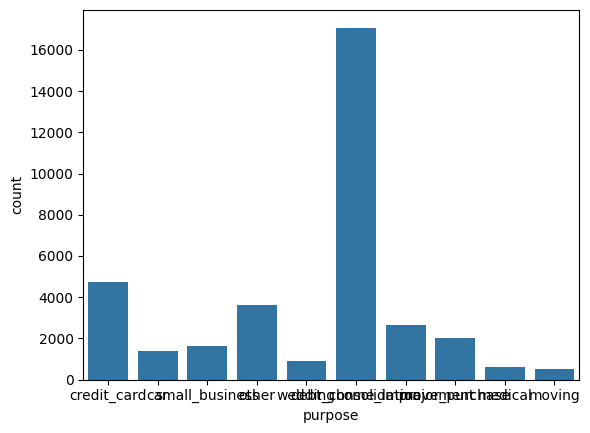

In [62]:
sns.countplot(loan, x="purpose")

# 6. Segmented Univariate Analysis

In [63]:
def plotUnivariateRatioBarSegmentedByDefaulter(feature, data=loan, rsorted=True):
    plt.figure(figsize=(20,10))
    feature_dimension = data[feature].unique()
    if rsorted:
        feature_dimension = data[feature].value_counts().index.array
    else:
        feature_dimension = data[feature].unique()
    totalCount = []
    for fd in feature_dimension:
        feature_filter = data[data[feature]==fd]
        # calculate features count in feature filter for defaulters
        defaulterCount = len(feature_filter[feature_filter["loan_status"]=="Charged Off"])
        totalCount.append(defaulterCount*100/feature_filter["loan_status"].count())
    df = pd.DataFrame({"feature_dimension": feature_dimension, "totalCount": totalCount}).sort_values(by=["totalCount"])
    plt.bar(df.feature_dimension, df.totalCount, color='orange', edgecolor='white')
    plt.title("Loan Defaults wrt "+str(feature)+" feature - countplot")
    plt.xlabel(feature, fontsize=16)
    plt.ylabel("defaulter %", fontsize=16)
    plt.show()

# function to plot univariate with default status scale 0 - 1
def plotUnivariateBarSegmentedByDefaulter(x):
    plt.figure(figsize=(20,10))
    #plot bar graph against feature on x-axis and loan status on y-axis
    sns.barplot(x=x, y='is_defaulter', data=loan)
    plt.title("Loan Defaults wrt "+str(x)+" - countplot")
    plt.xlabel(x, fontsize=16)
    plt.ylabel("defaulter ratio", fontsize=16)
    plt.show()

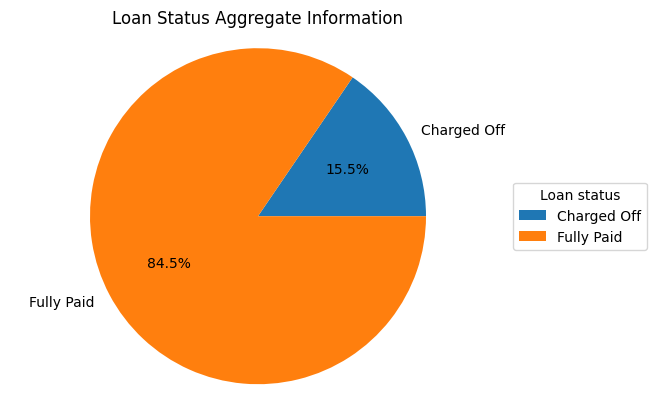

In [64]:
# plotting pie chart for different types of loan status
loan_status_grouped_data = loan.groupby(['loan_status'])['funded_amnt_inv'].sum().reset_index()

plt.figure()
plt.pie(loan_status_grouped_data["funded_amnt_inv"],labels=loan_status_grouped_data["loan_status"],autopct='%1.1f%%')
plt.title('Loan Status Aggregate Information')
plt.axis('equal')
plt.legend(title="Loan status",loc="center left",bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

In [65]:
loan["purpose"].value_counts()

purpose
debt_consolidation    17085
credit_card            4750
other                  3602
home_improvement       2632
major_purchase         2017
small_business         1646
car                    1409
wedding                 899
medical                 629
moving                  536
Name: count, dtype: int64

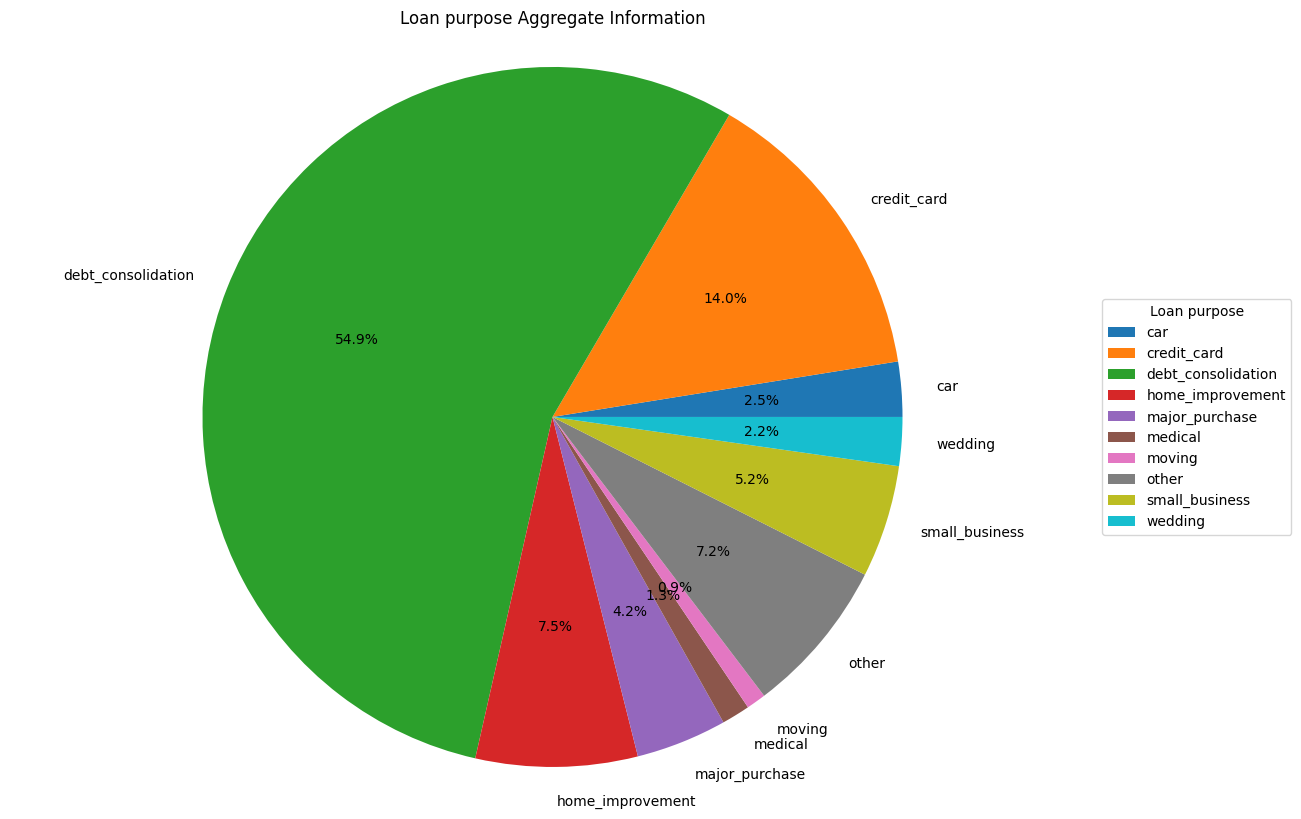

In [66]:
# plotting pie chart for different types of purpose
loans_purpose_grouped_data = loan.groupby(['purpose'])['funded_amnt_inv'].sum().reset_index()

plt.figure(figsize=(14, 10))
plt.pie(loans_purpose_grouped_data["funded_amnt_inv"],labels=loans_purpose_grouped_data["purpose"],autopct='%1.1f%%')
plt.title('Loan purpose Aggregate Information')
plt.axis('equal')
plt.legend(title="Loan purpose",loc="center left",bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

### 6.1 Categorical Columns

In [67]:
#get term values
loan["term"].value_counts()

term
36    26512
60     8693
Name: count, dtype: int64

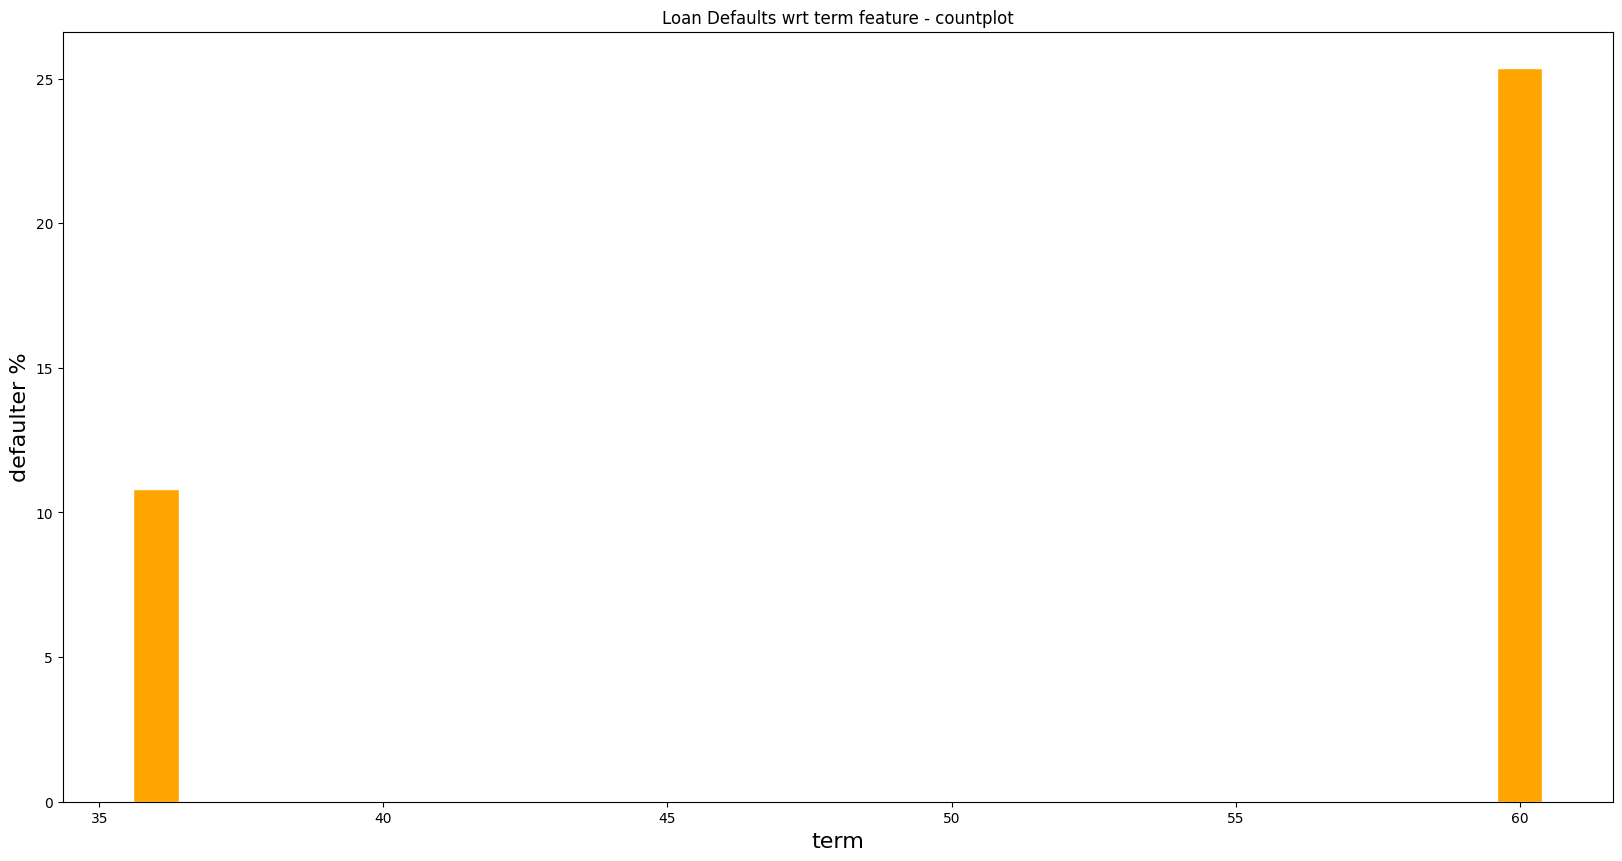

In [68]:
# check for defaulters wrt term in the data using countplot
plotUnivariateRatioBarSegmentedByDefaulter("term")

From above plot for `term` we can infer that the defaulters rate is increasing wrt term ie. The number of payments on the loan, hence the chances of loan getting deaulted is less for 36m than 60m.

so `term` can become a deciding variable for loan approval.

In [69]:
#get grade values
loan["grade"].value_counts()

grade
B    10709
A     9065
C     7212
D     4686
E     2411
F      862
G      260
Name: count, dtype: int64

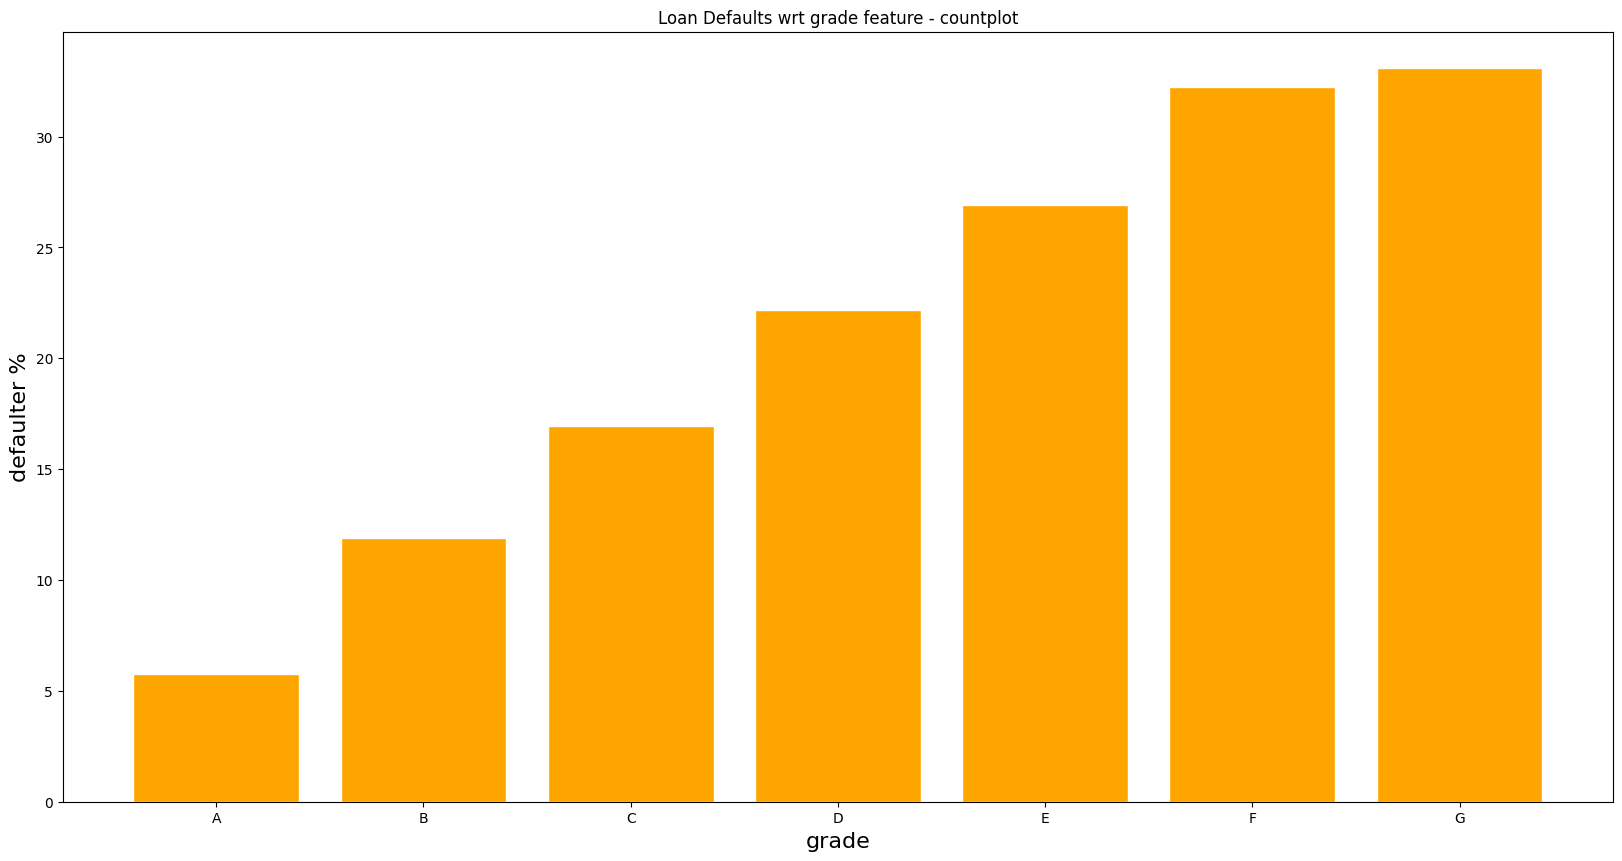

In [70]:
# check for defaulters wrt grade in the data using countplot
plotUnivariateRatioBarSegmentedByDefaulter("grade")

From above plot for `grade` we can infer that the defaulters rate is increasing wrt grade, hence the chances of loan getting deaulted increases with the grade from A moving towards G.

so `grade` can become a deciding variable for loan approval.

In [71]:
#get sub_grade values
loan["sub_grade"].value_counts()

sub_grade
A4    2629
B3    2580
A5    2468
B5    2430
B4    2245
C1    1905
B2    1830
C2    1768
A3    1635
B1    1624
C3    1365
A2    1341
D2    1188
C4    1114
C5    1060
D3    1027
A1     992
D1     860
D4     851
D5     760
E1     671
E2     546
E3     464
E4     390
E5     340
F1     268
F2     209
F3     149
F4     135
F5     101
G1      85
G2      69
G3      43
G4      41
G5      22
Name: count, dtype: int64

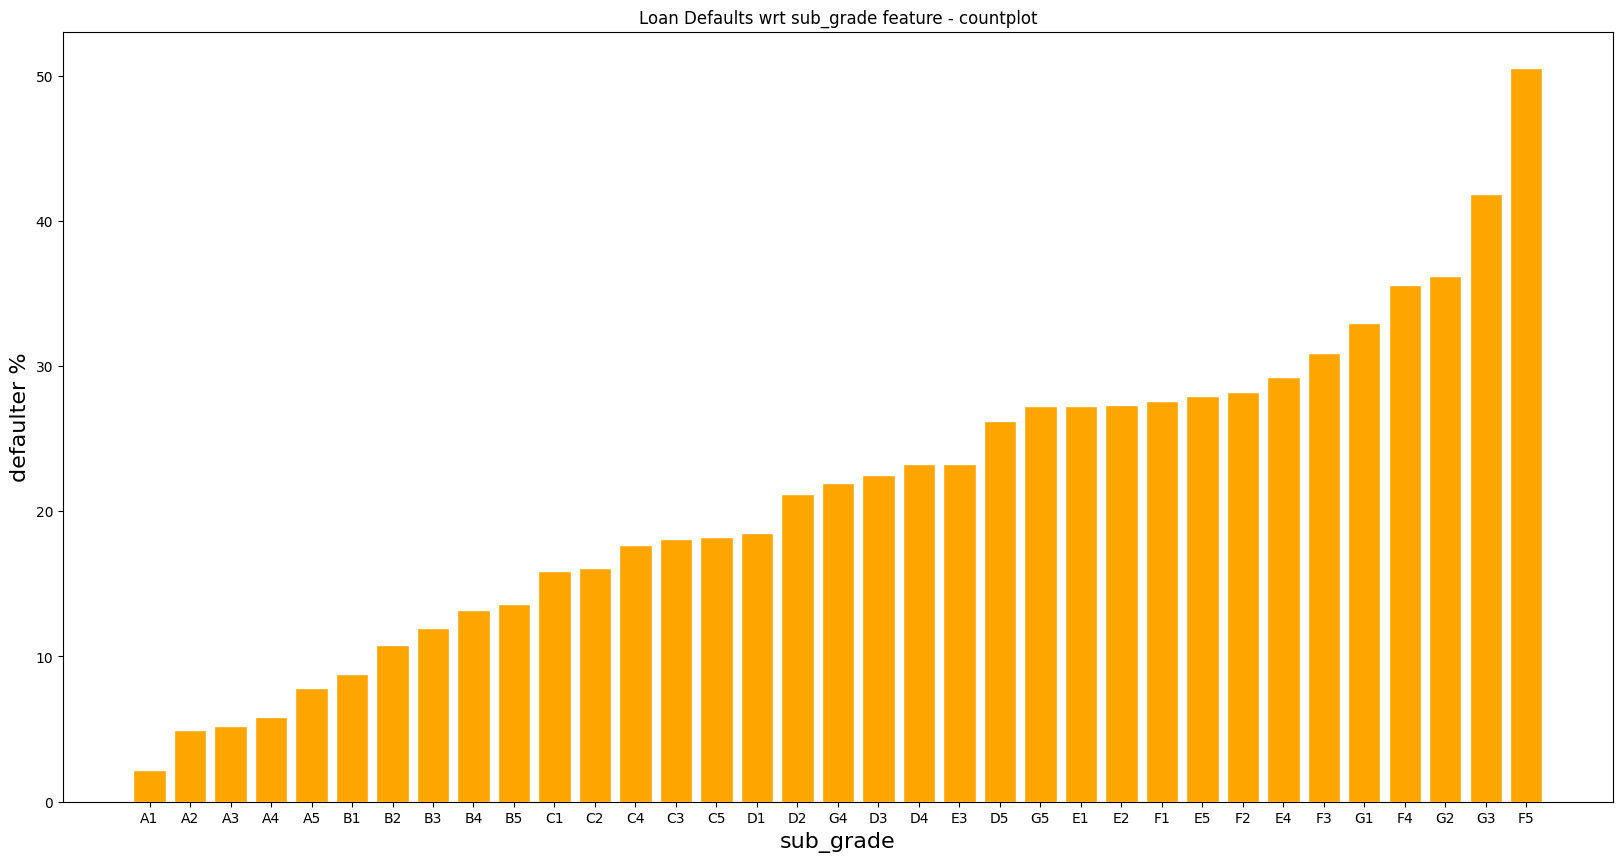

In [72]:
# check for defaulters wrt sub_grade in the data using countplot
plotUnivariateRatioBarSegmentedByDefaulter("sub_grade")

From above plot for `sub_grade` we can infer that the defaulters rate is increasing wrt `sub_grade`, hence the chances of loan getting deaulted increases with the `sub_grade` from A1 moving towards G5.

so `‘sub_grade’` can become a deciding variable for loan approval.

In [73]:
#get home_ownership values
loan["home_ownership"].value_counts()

home_ownership
RENT        17163
MORTGAGE    15347
OWN          2602
OTHER          90
NONE            3
Name: count, dtype: int64

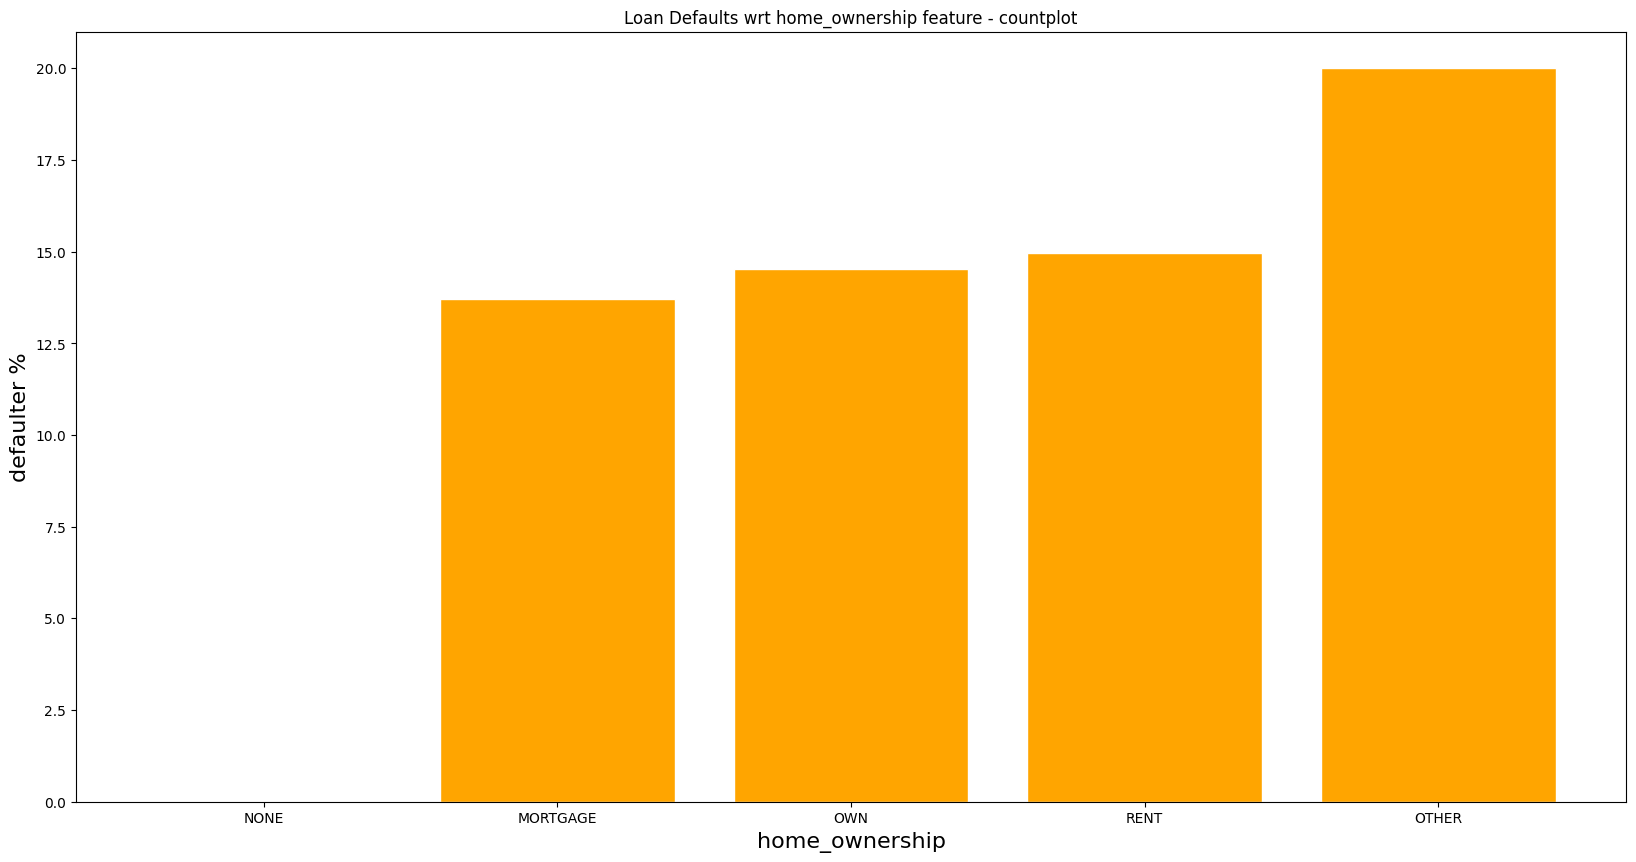

In [74]:
# check for defaulters wrt home_ownership in the data 
plotUnivariateRatioBarSegmentedByDefaulter("home_ownership")

From above plot for `home_ownership` we can infer that the defaulters rate is almost constant here (it is quite more for OTHERS but we dont know what is in there, so we’ll not consider it for analysis), hence defaulter does not depends on `home_ownership`

In [75]:
#get verification_status values
loan["verification_status"].value_counts()

verification_status
Not Verified       15304
Verified           10968
Source Verified     8933
Name: count, dtype: int64

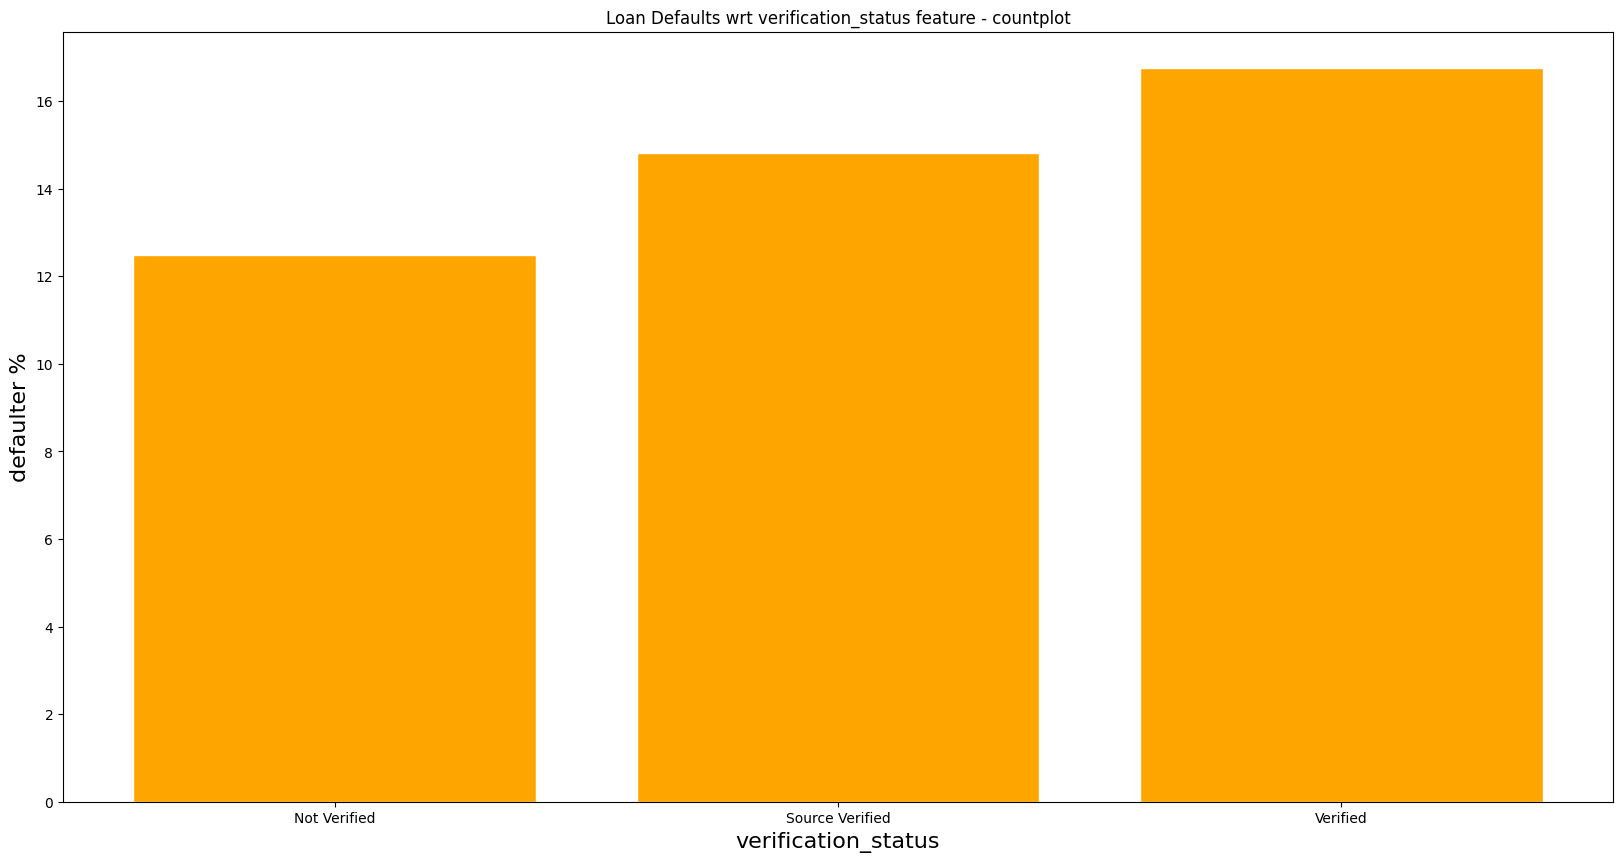

In [76]:
# check for defaulters wrt verification_status in the data
plotUnivariateRatioBarSegmentedByDefaulter("verification_status")

From above plot for `verification_status` we can infer that the defaulters rate is increasing and is less for Not Verified users than Verified ones, but not useful for analysis.

but we can not deduce that verified users are likely to be defaulter.

In [77]:
#get purpose values
loan["purpose"].value_counts()

purpose
debt_consolidation    17085
credit_card            4750
other                  3602
home_improvement       2632
major_purchase         2017
small_business         1646
car                    1409
wedding                 899
medical                 629
moving                  536
Name: count, dtype: int64

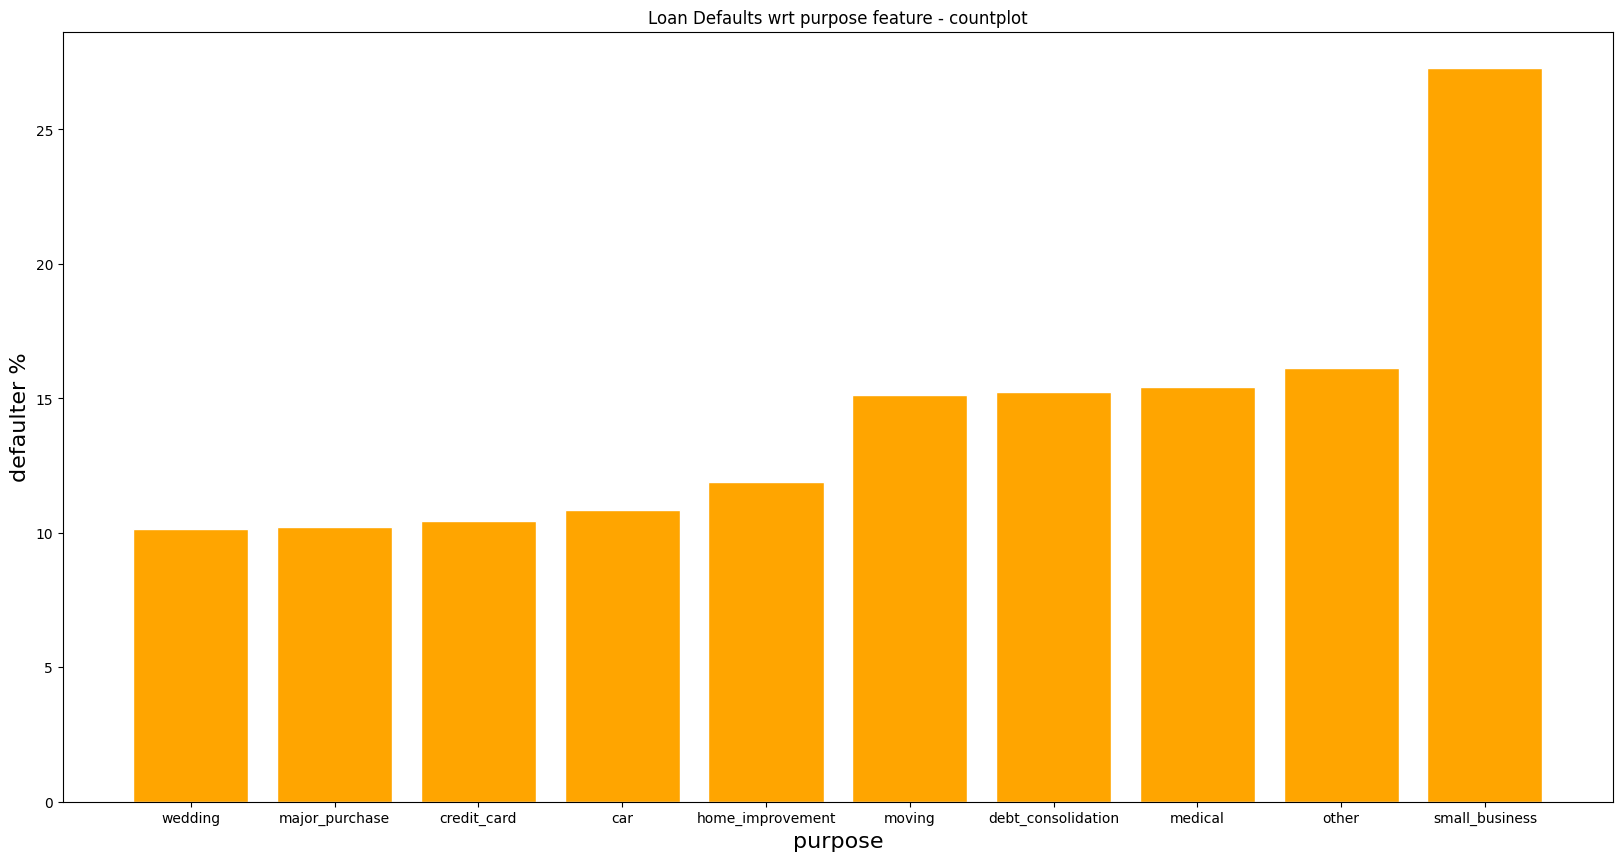

In [78]:
# check for defaulters wrt purpose in the data using countplot
plotUnivariateRatioBarSegmentedByDefaulter("purpose")

From above plot for `purpose` we can infer that the defaulters rate is nearly constant for all purpose type except ‘small business’, hence rate will depend on purpose of the loan.

In [79]:
#get open_acc values
loan["open_acc"].value_counts()

open_acc
7     3678
6     3569
8     3559
9     3399
10    2892
5     2847
11    2474
4     2126
12    2035
13    1704
3     1327
14    1279
15    1010
16     811
17     607
2      503
18     432
19     303
20     221
21     163
22      91
23      59
24      35
25      35
26      16
28      13
27      11
29       6
Name: count, dtype: int64

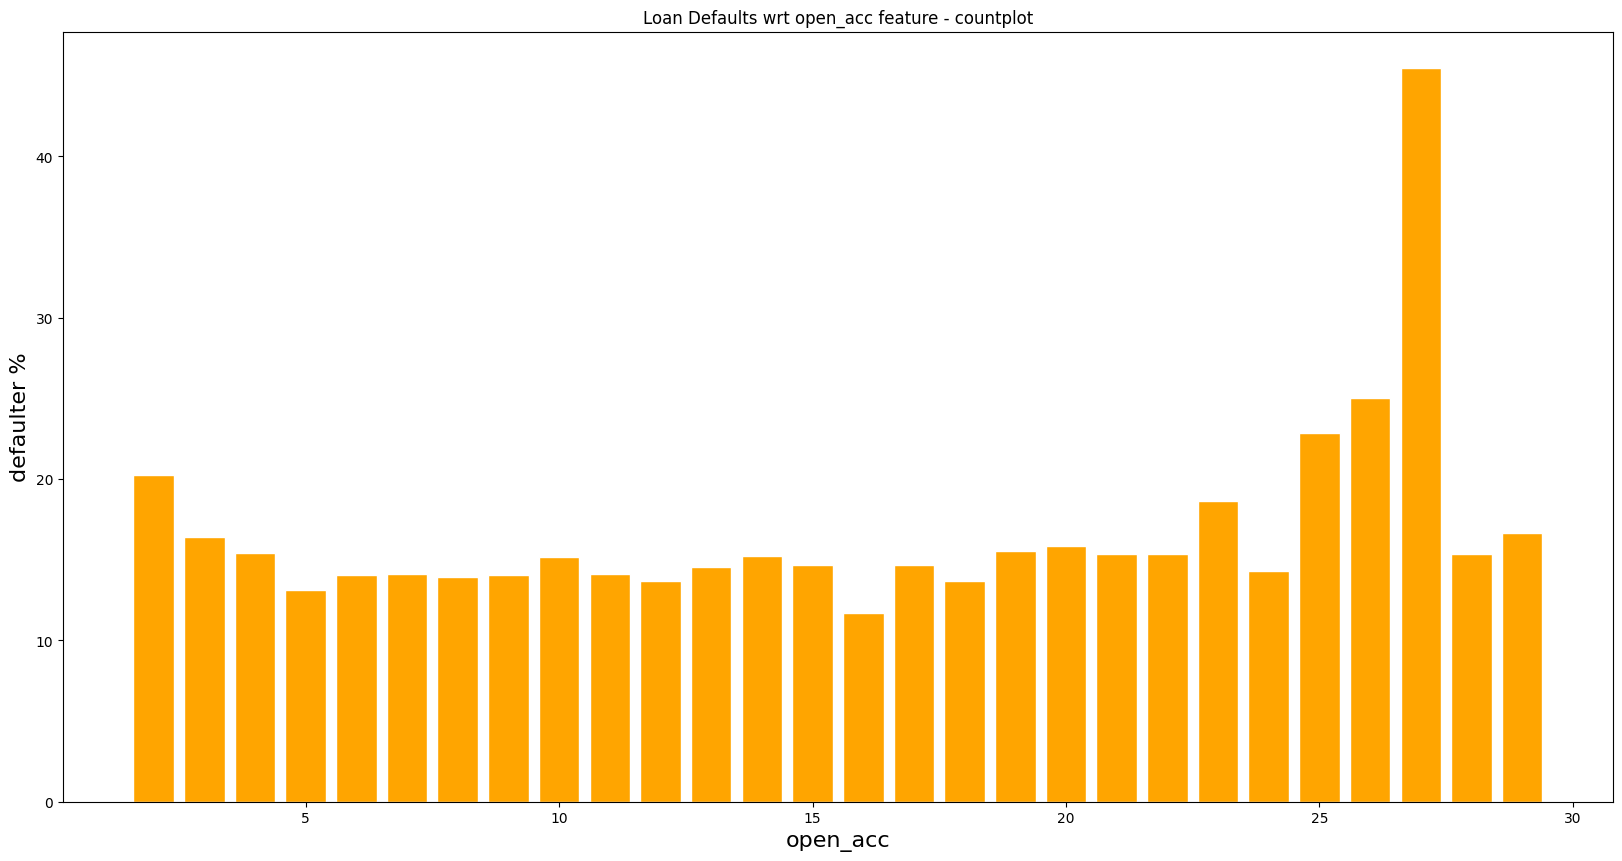

In [80]:
# check for defaulters wrt open_acc in the data using countplot
plotUnivariateRatioBarSegmentedByDefaulter("open_acc")

From above plot for `open_acc` we can infer that the defaulters rate is nearly constant for feature open_acc, hence rate will not depend on open_acc feature ie. The number of open credit lines in the borrower's credit file doesn't qualify loan approval metric.

In [81]:
#get pub_rec values
loan["pub_rec"].value_counts()

pub_rec
0    33348
1     1804
2       44
3        7
4        2
Name: count, dtype: int64

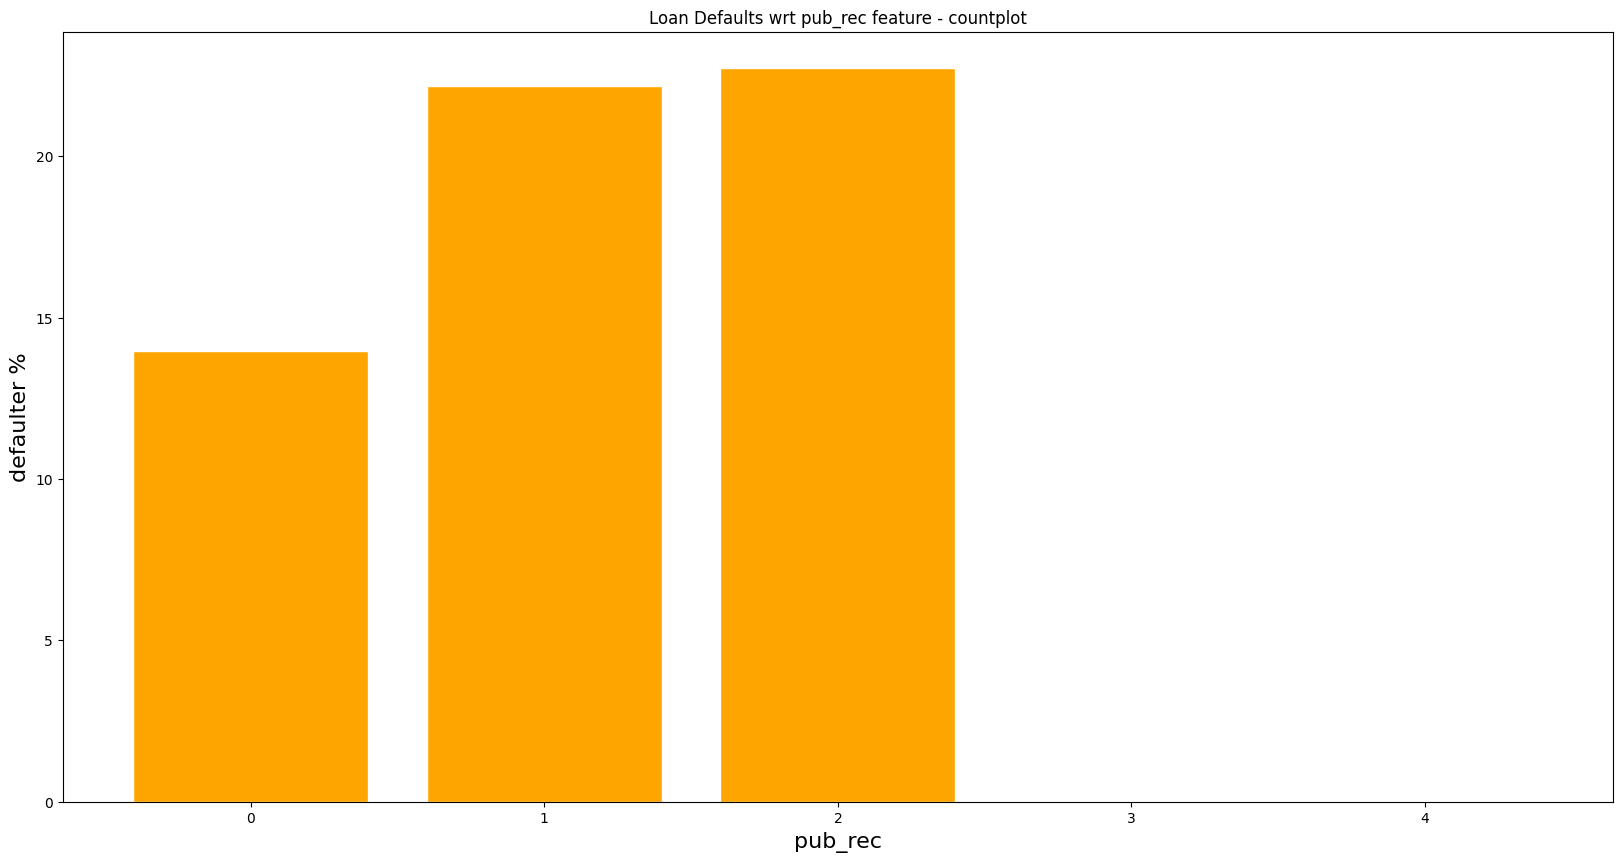

In [82]:
# check for defaulters wrt pub_rec in the data using countplot
plotUnivariateRatioBarSegmentedByDefaulter("pub_rec")

From above plot for `pub_rec` we can infer that the defaulters rate is nearly increasing as it is less for 0 and more for pub_rec with value 1, but as other values are very less as compared to 0 we’ll not consider this for analysis.

In [85]:
#get pub_rec_bankruptcies values
loan["pub_rec_bankruptcies"].value_counts()

pub_rec_bankruptcies
0.0    33093
1.0     1461
2.0        5
Name: count, dtype: int64

In [84]:
loan[["loan_status", "pub_rec_bankruptcies"]].value_counts(normalize=True)

loan_status  pub_rec_bankruptcies
Fully Paid   0.0                     0.823201
Charged Off  0.0                     0.134379
Fully Paid   1.0                     0.033074
Charged Off  1.0                     0.009202
Fully Paid   2.0                     0.000087
Charged Off  2.0                     0.000058
Name: proportion, dtype: float64

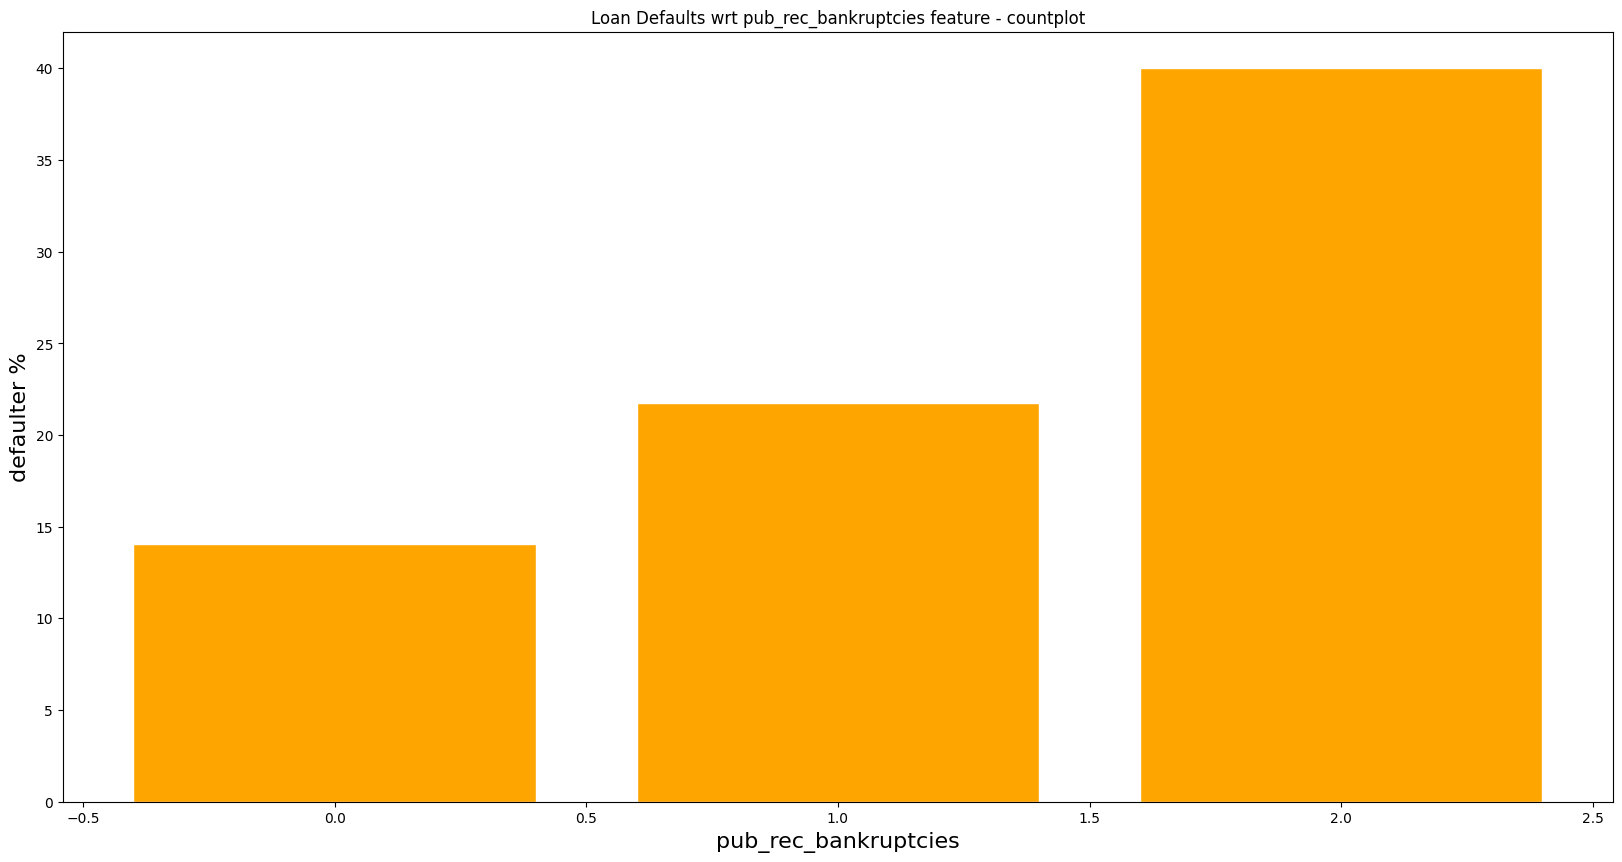

In [237]:
# check for defaulters wrt pub_rec_bankruptcies in the data using countplot
plotUnivariateRatioBarSegmentedByDefaulter("pub_rec_bankruptcies")

From above plot for `pub_rec_bankruptcies` we can infer that the defaulters rate is nearly increasing as it is less for 0 and more for pub_rec_bankruptcies with value 1, but as other values are very less as compared to 0 we’ll not consider this for analysis.

b. Continuous Features

In [238]:
#get emp_length values
loan["emp_length"].value_counts()

emp_length
10    7814
0     4264
2     4039
3     3801
4     3135
5     3009
1     2990
6     2054
7     1611
8     1349
9     1139
Name: count, dtype: int64

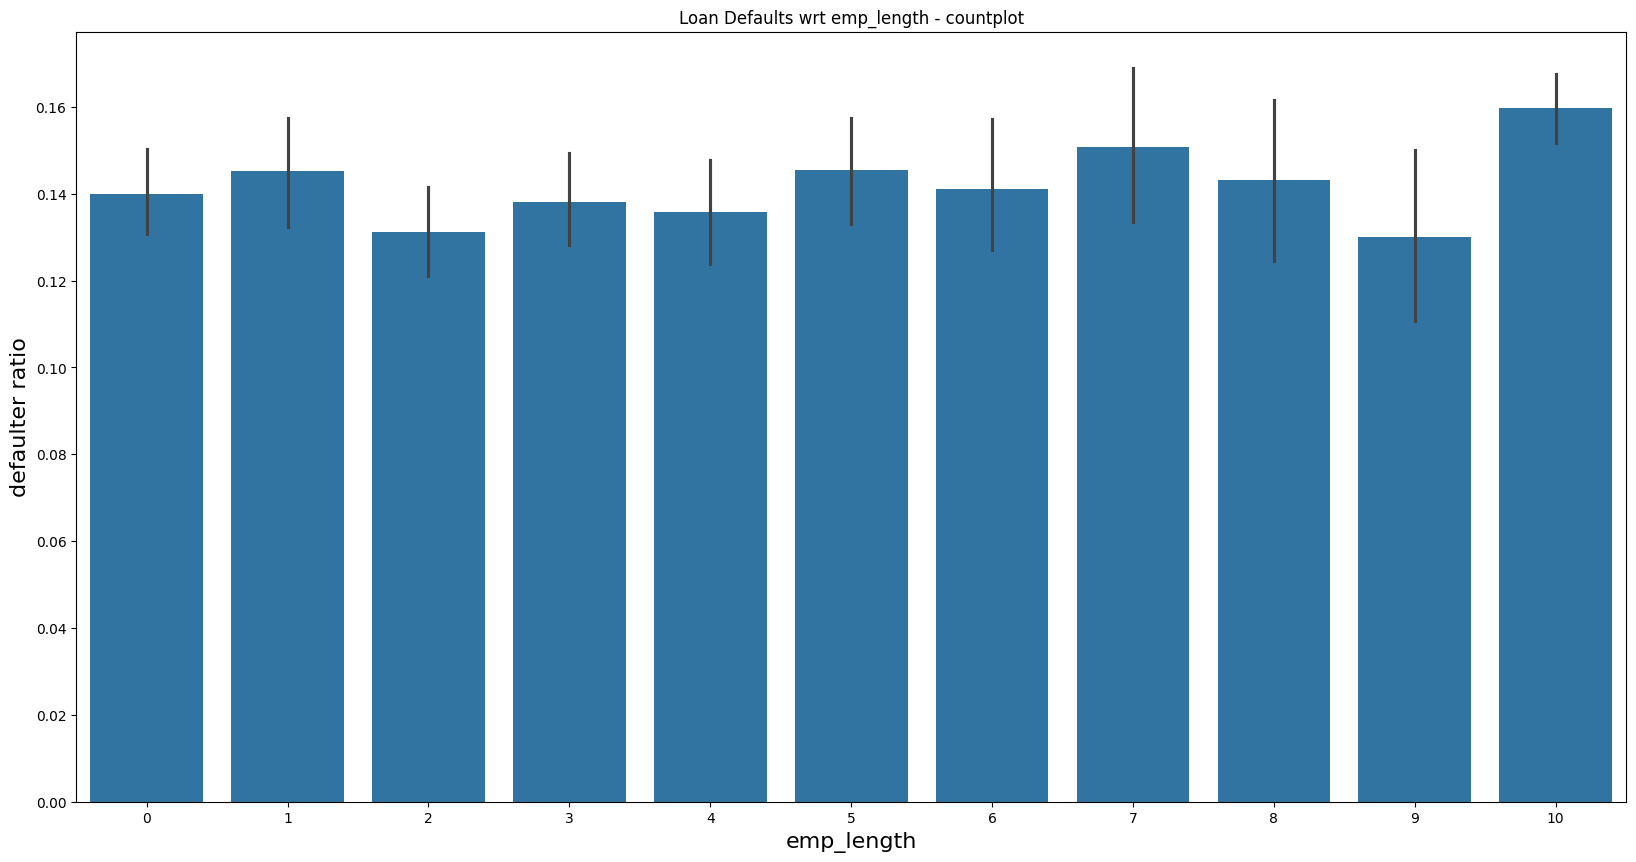

In [239]:
# check for defaulters wrt emp_length in the data using countplot
plotUnivariateBarSegmentedByDefaulter("emp_length")

From above plot for `emp_length` we can infer that the defaulters rate is constant here, hence defaulter does not depends on Employment length in years.

In [240]:
#get month value counts
loan["issue_d_month"].value_counts()

issue_d_month
12    3909
11    3661
10    3389
9     3170
8     3115
7     3061
6     2883
5     2651
4     2589
3     2455
1     2193
2     2129
Name: count, dtype: int64

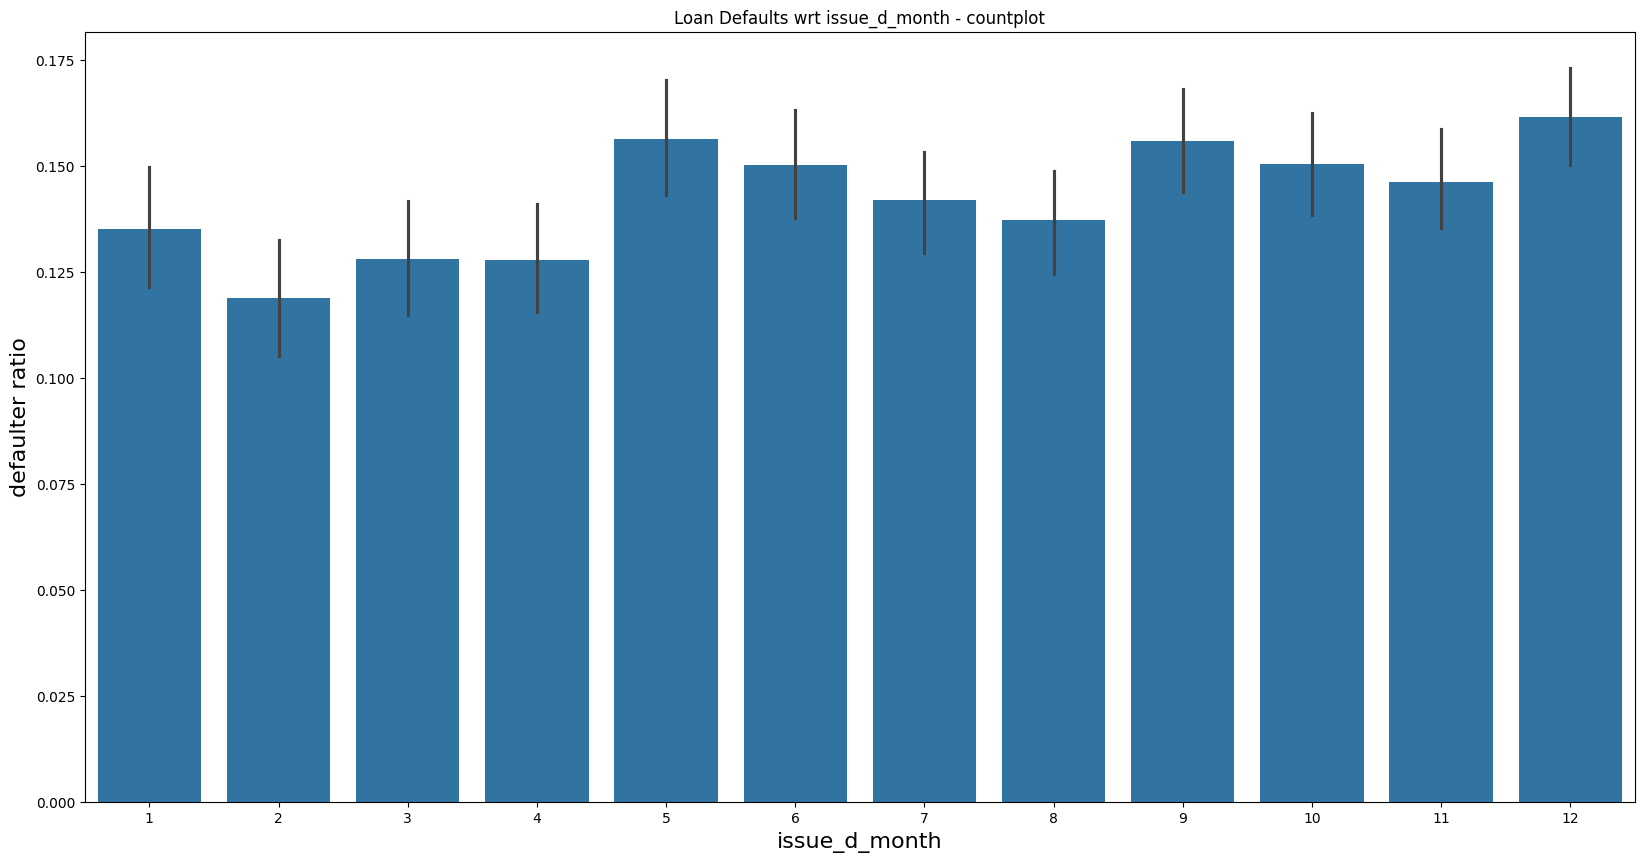

In [241]:
# check for defaulters wrt month in the data using countplot
plotUnivariateBarSegmentedByDefaulter("issue_d_month")

From above plot for `month` we can infer that the defaulters rate is nearly constant here, hence not useful

In [242]:
#get year value counts
loan["issue_d_year"].value_counts()

issue_d_year
2011    18732
2010    10500
2009     4308
2008     1436
2007      229
Name: count, dtype: int64

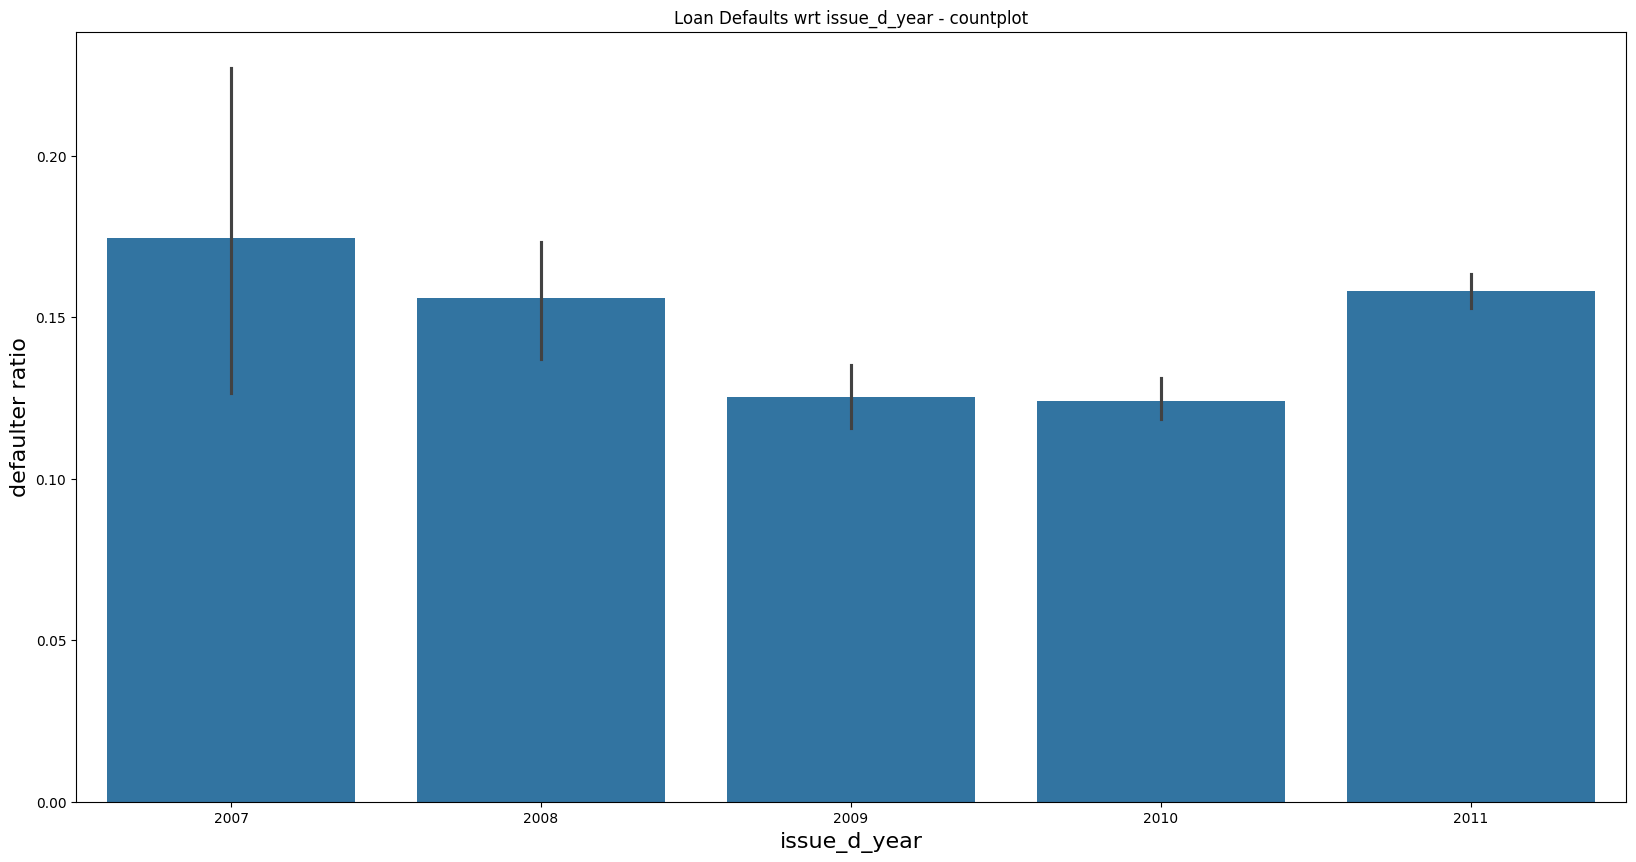

In [243]:
# check for defaulters wrt year in the data using countplot
plotUnivariateBarSegmentedByDefaulter("issue_d_year")

From above plot for `year` we can infer that the defaulters rate is nearly constant here, hence not useful for analysis.

In [244]:
#get earliest_cr_line value counts
loan["earliest_cr_line_year"].value_counts()

earliest_cr_line_year
2000    2973
1999    2720
1998    2558
2001    2322
1997    2186
1996    2013
1995    1901
2002    1770
1994    1762
2003    1724
2004    1650
2005    1368
1993    1292
2006    1061
1992     936
1990     883
1991     851
1989     724
2007     658
1988     612
1987     516
1986     406
1985     382
1984     329
1983     278
1982     175
1981     146
1980     140
2008     135
1979     127
1978     125
1977      88
1976      70
1975      62
1974      44
1973      41
1971      37
1970      32
1972      32
1969      25
1968      14
1967      12
1966       7
1963       6
1965       5
1962       2
1956       1
1946       1
1950       1
1954       1
1964       1
Name: count, dtype: int64

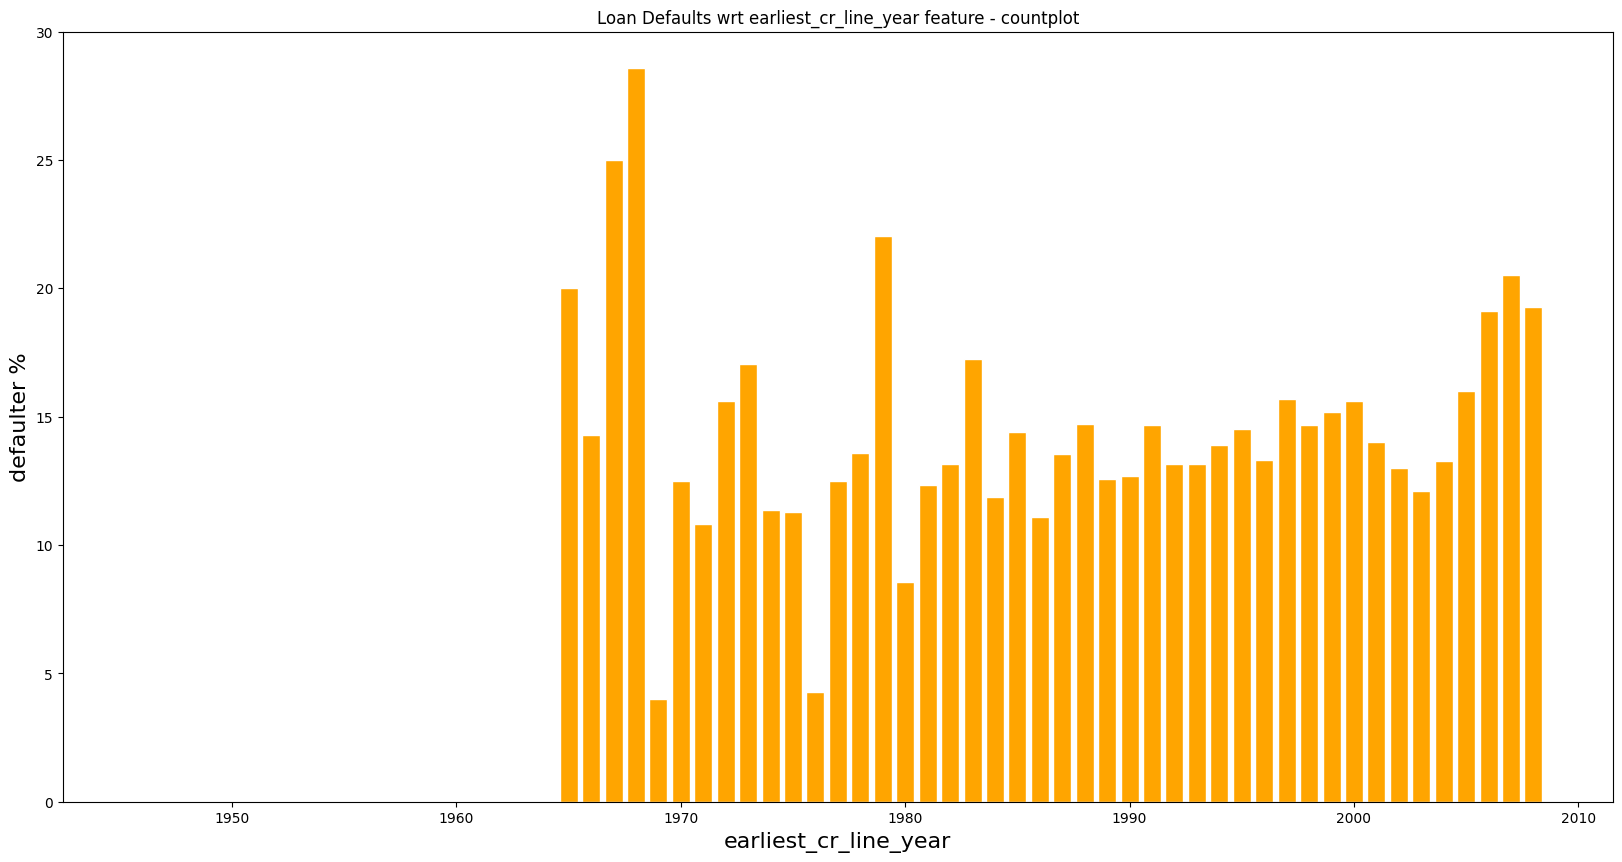

In [245]:
# check for defaulters wrt earliest_cr_line in the data
plotUnivariateRatioBarSegmentedByDefaulter("earliest_cr_line_year")

From above plot for `earliest_cr_line` we can infer that the defaulters rate is nearly constant for all purpose type except year around 65, hence rate does not depends on earliest_cr_line ie. The month the borrower's earliest reported credit line was opened will not be useful for analysis.

In [246]:
#get inq_last_6mths value counts
loan["inq_last_6mths"].value_counts()

inq_last_6mths
0    17279
1     9717
2     5086
3     2648
4      270
5      119
6       53
7       23
8       10
Name: count, dtype: int64

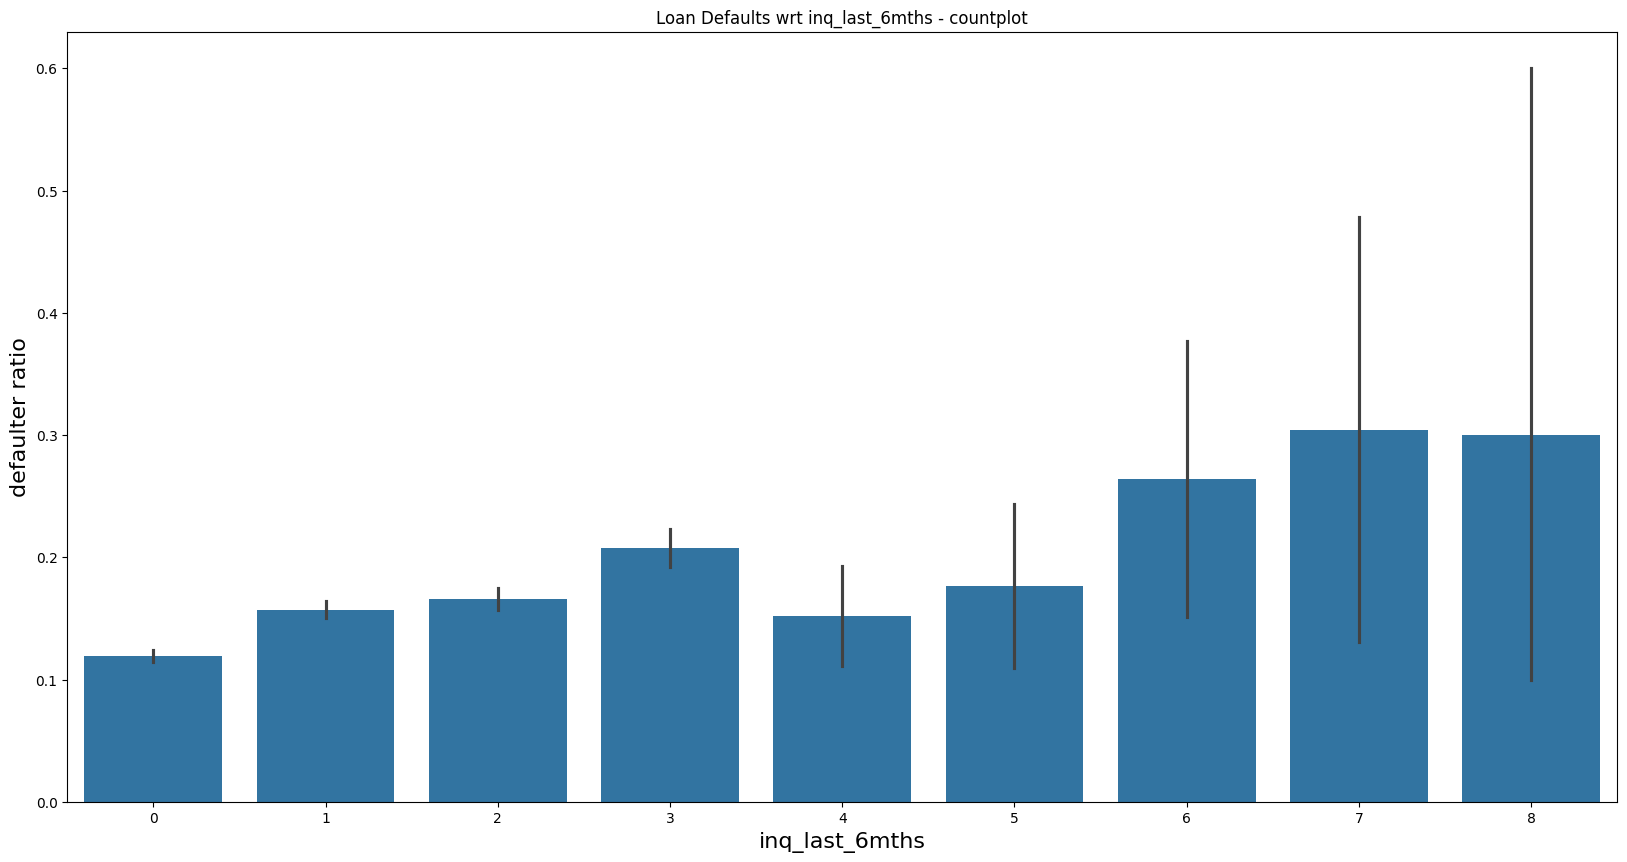

In [247]:
# check for defaulters wrt inq_last_6mths in the data
plotUnivariateBarSegmentedByDefaulter("inq_last_6mths")

From above plot for `inq_last_6mths` we can infer that the defaulters rate is not consistently increasing with inq_last_6mths ie. The number of inquiries in past 6 months (excluding auto and mortgage inquiries), hence not useful for analysis.

From above plot for `revol_util` we can infer that the defaulters rate is fluctuating where some have complete 100% ratio for defaulter and is increasing as the magnitude increases, hence rate will depend on revol_util feature ie. Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit is useful feature for loan analysis.

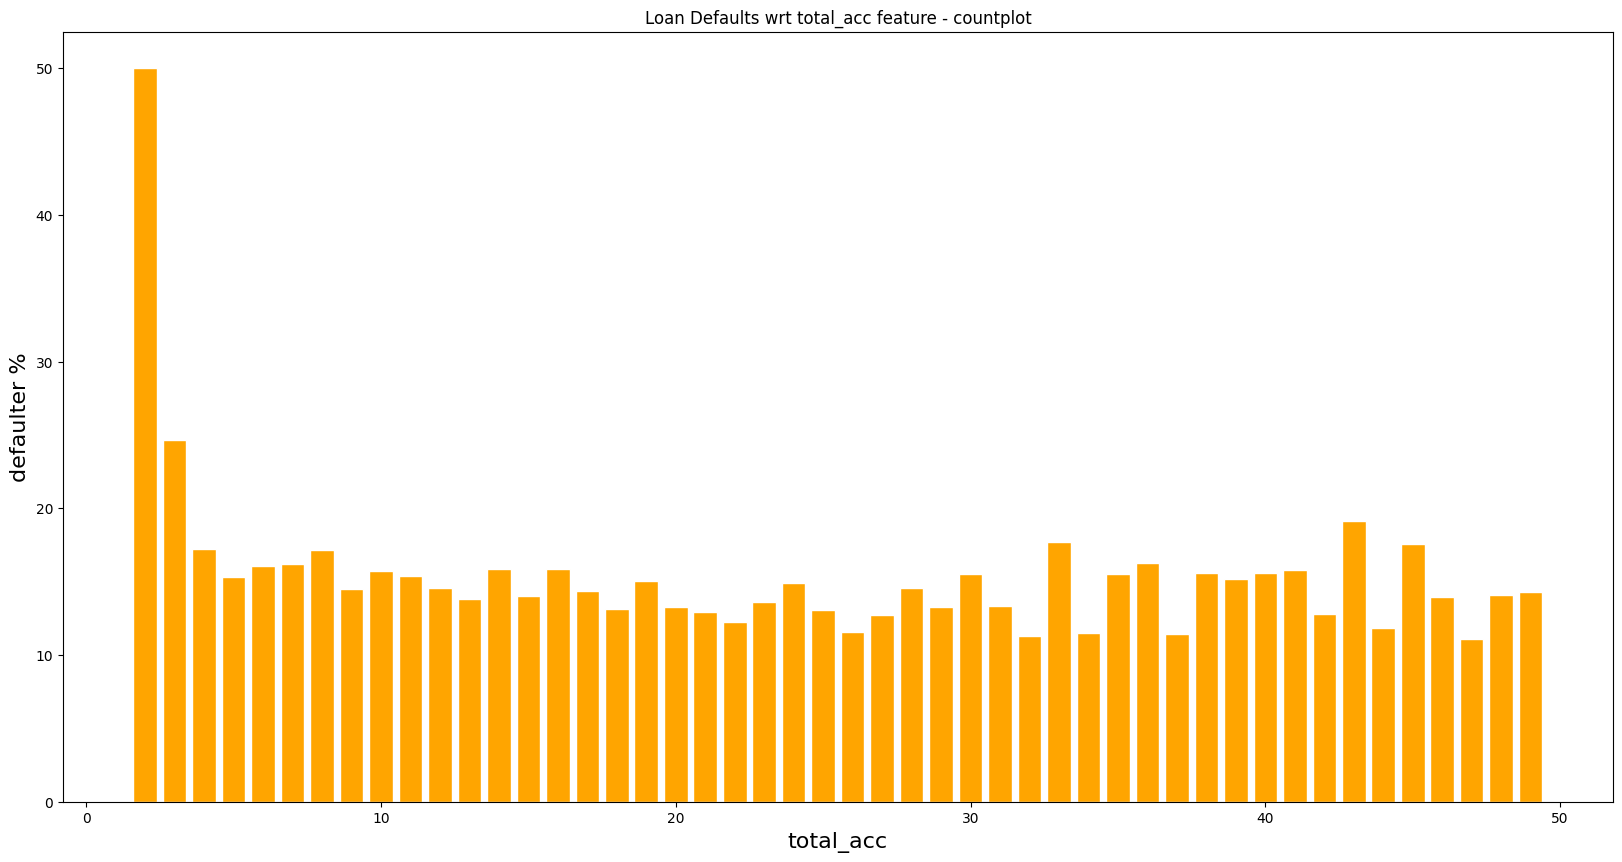

In [248]:
# check for defaulters wrt total_acc in the data using countplot
plotUnivariateRatioBarSegmentedByDefaulter("total_acc")

From above plot for `total_acc` we can infer that the defaulters rate is nearly constant for all total_acc values ie. The total number of credit lines currently in the borrower's credit file, hence rate will not depend on total_acc feature

### 6.2 Binned Columns for Continuous Data Types

In [249]:
#get revol_util value counts
loan["revol_util_range"].value_counts()

revol_util_range
40    3870
60    3856
50    3852
30    3643
70    3623
20    3341
80    3335
0     3042
10    2939
90    2861
Name: count, dtype: int64

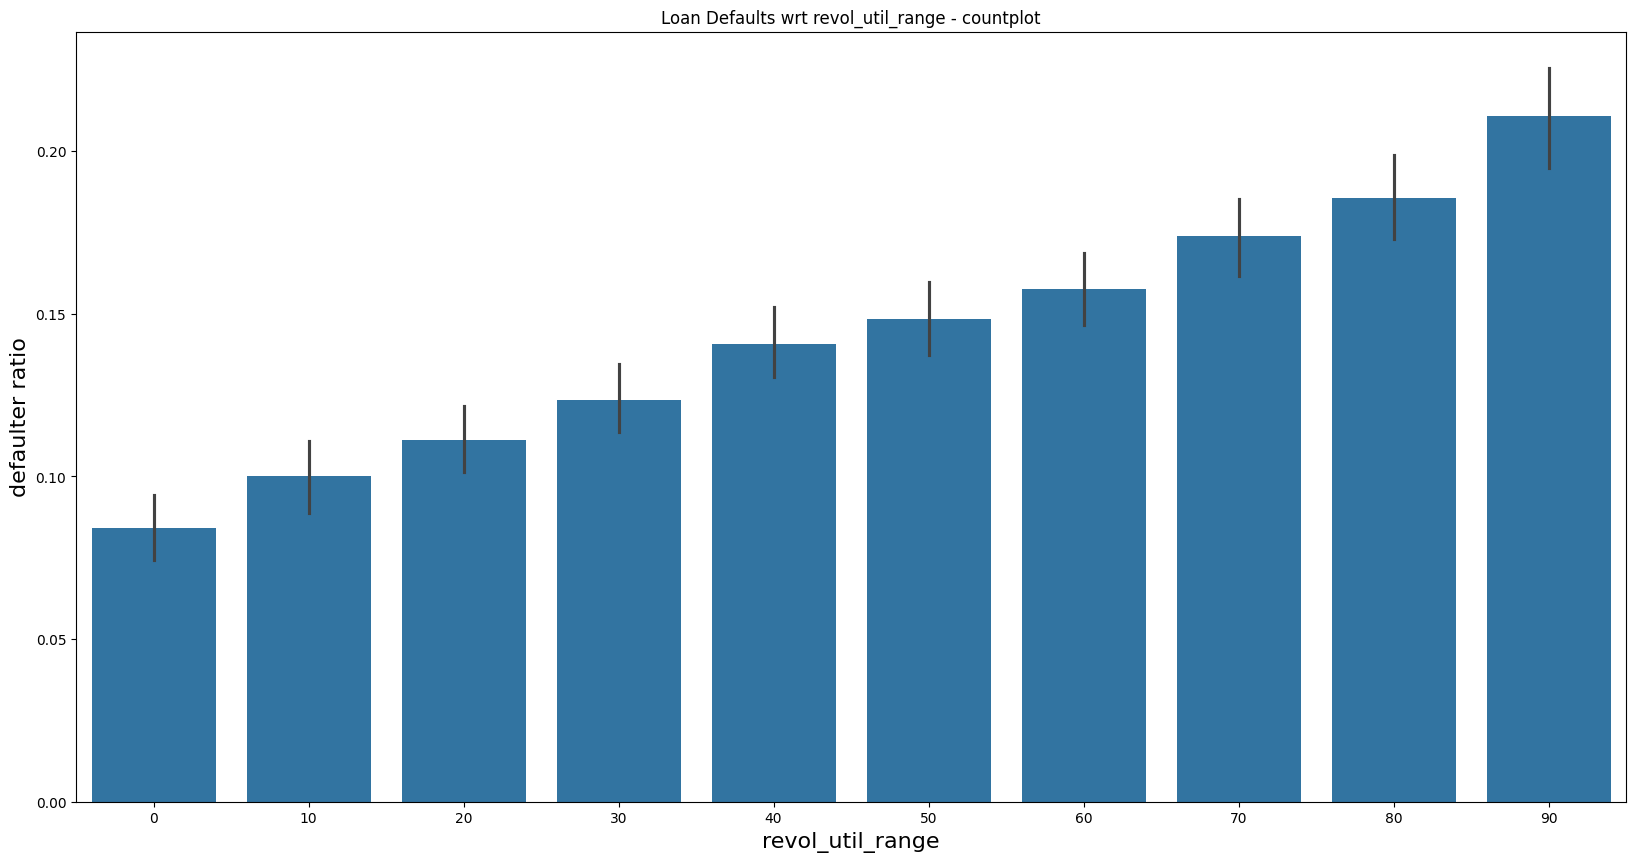

In [250]:
# check for defaulters wrt revol_util in the data using countplot
plotUnivariateBarSegmentedByDefaulter("revol_util_range")

In [251]:
#get loan_amnt_range value counts
loan["loan_amnt_range"].value_counts()

loan_amnt_range
5000-10000     11813
0-5000          8403
10000-15000     7168
15000-20000     4016
20000-25000     2565
25000+          1240
Name: count, dtype: int64

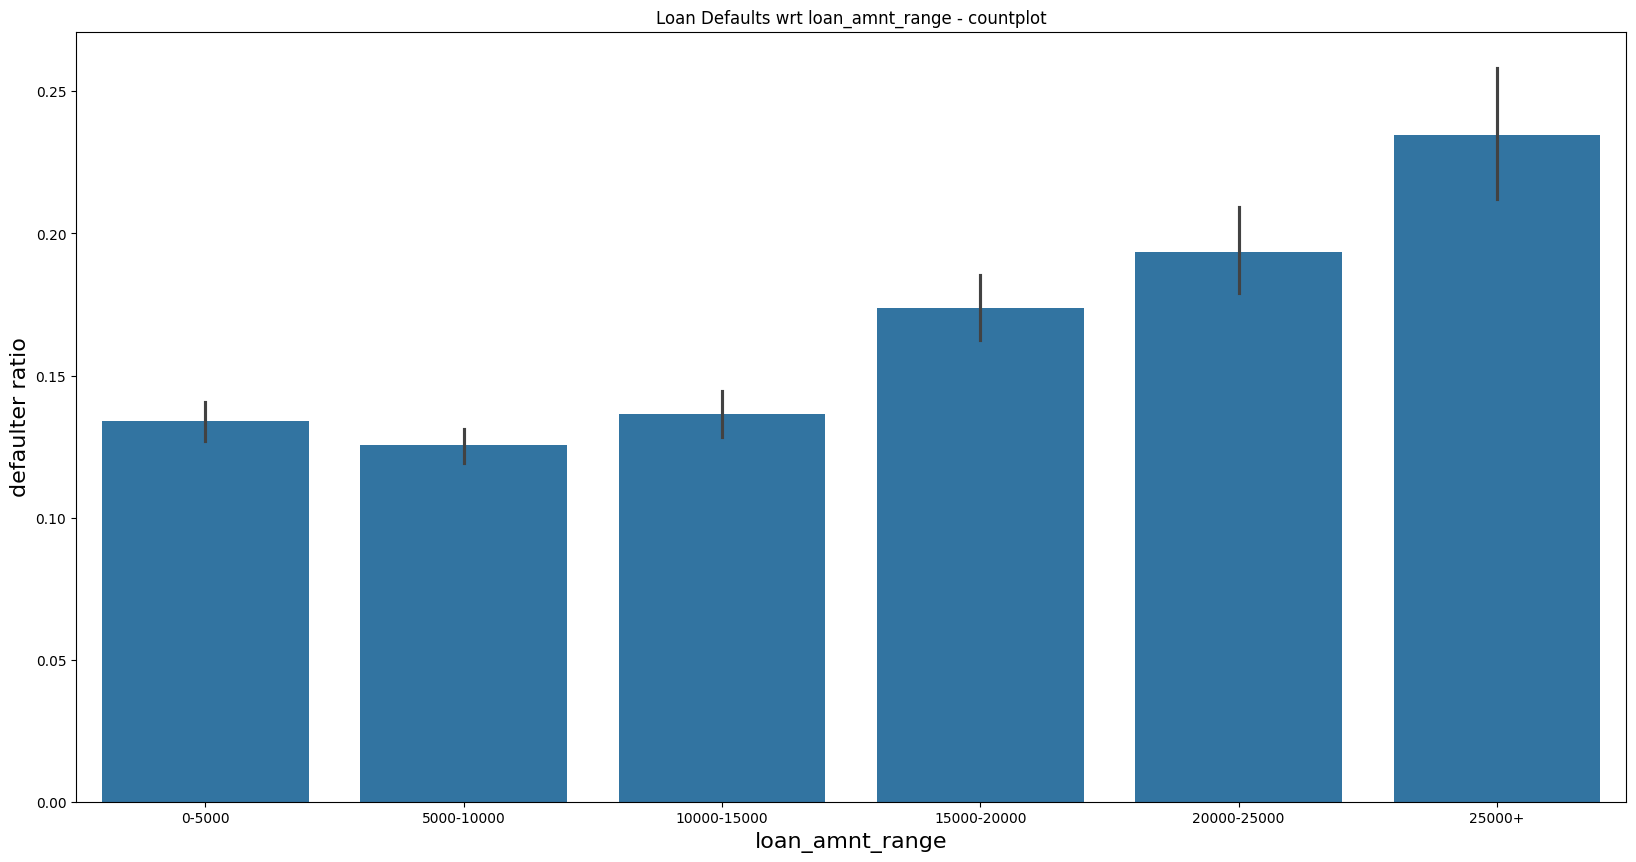

In [252]:
# check for defaulters wrt loan_amnt_range in the data using countplot
plotUnivariateBarSegmentedByDefaulter("loan_amnt_range")    

From above plot for `loan_amnt_range` we can infer that the defaulters rate is increasing with loan_amnt_range values, hence rate will depend on loan_amnt_range feature. so as loan amount range increases chances for loan will be defaulted increases.

In [253]:
#get int_rate_range value counts
loan["int_rate_range"].value_counts()

int_rate_range
10-12.5    8630
12.5-15    8201
15+        7260
7.5-10     6300
0-7.5      4814
Name: count, dtype: int64

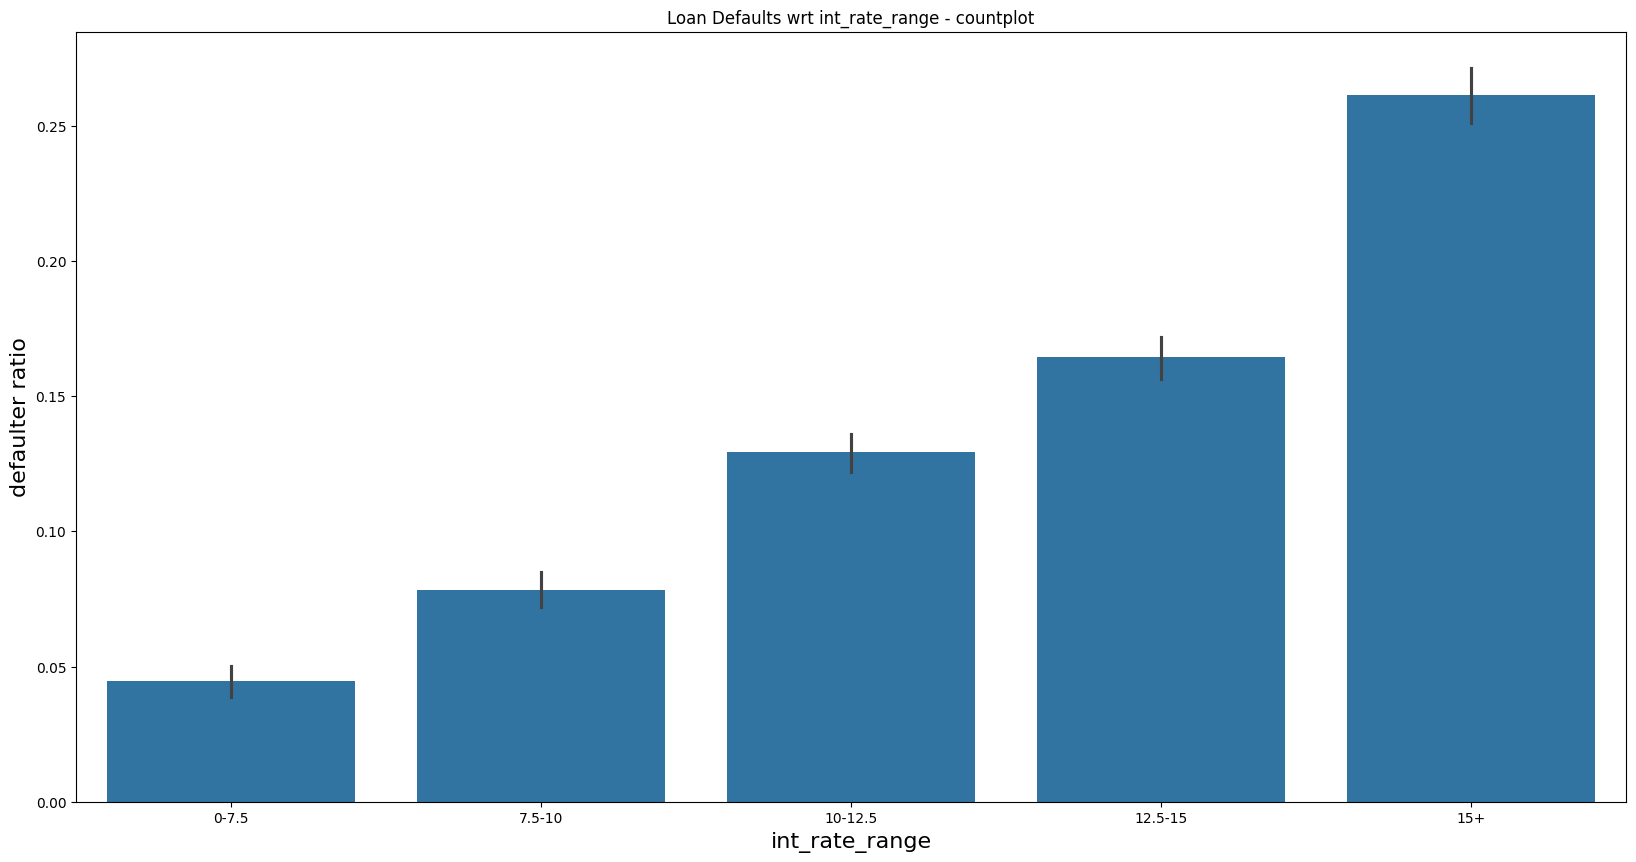

In [254]:
# check for defaulters wrt int_rate_range in the data
plotUnivariateBarSegmentedByDefaulter("int_rate_range")

From above plot for `int_rate_range` we can infer that the defaulters rate is decreasing with int_rate_range values, hence rate will depend on int_rate_range feature

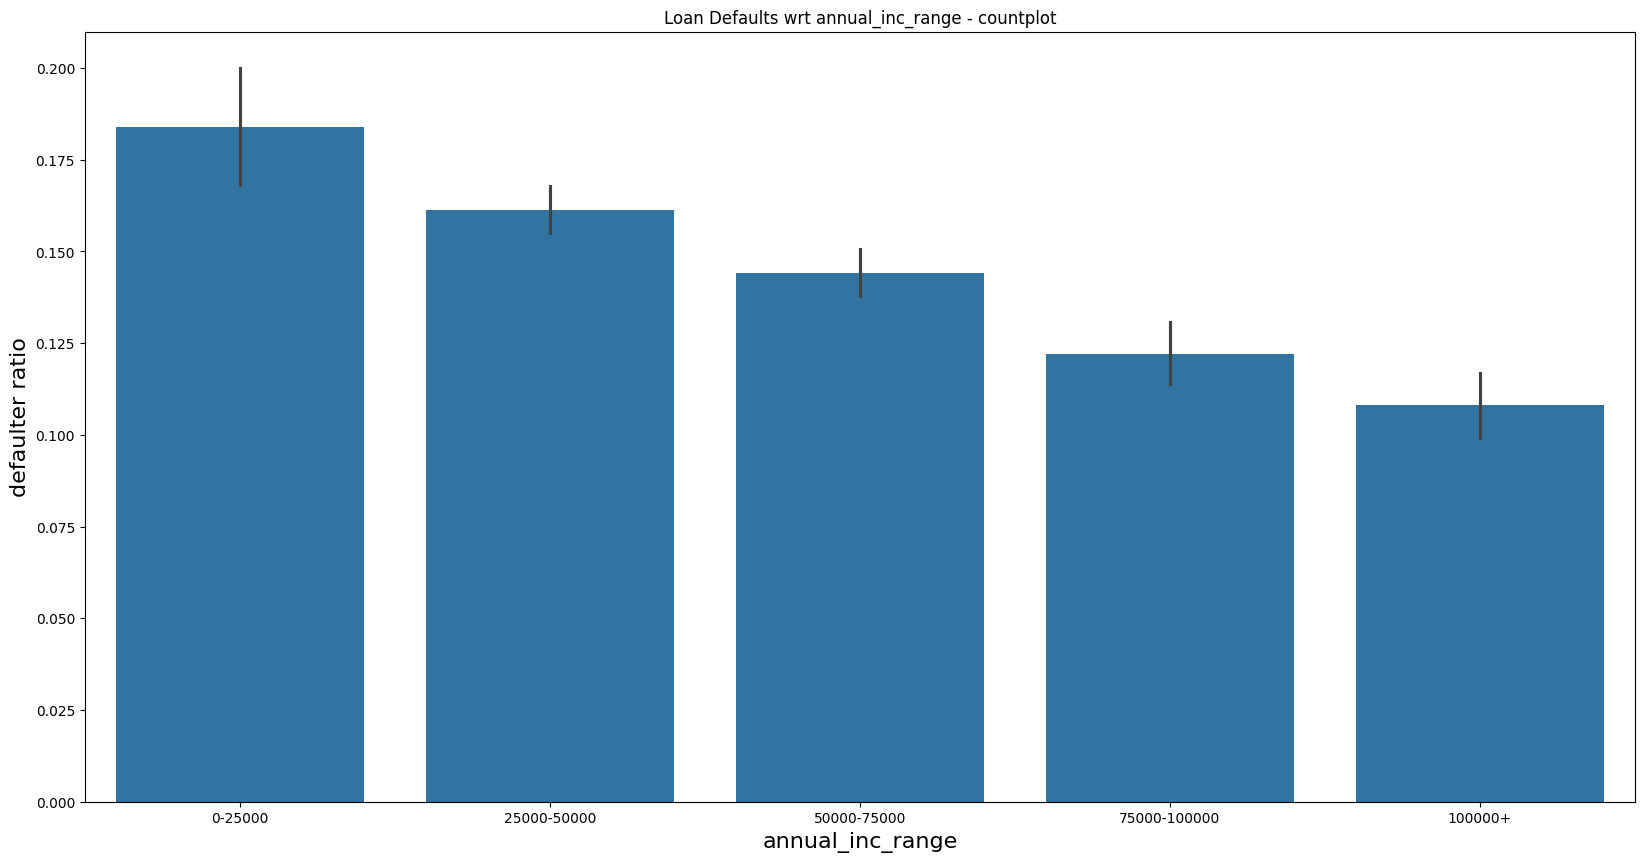

In [255]:
# check for defaulters wrt annual_inc_range in the data
plotUnivariateBarSegmentedByDefaulter("annual_inc_range")

From above plot for `annual_inc_range` we can infer that the defaulters rate is decreasing as with annual_inc_range values, hence rate will depend on annual_inc_range feature.

In [256]:
#get dti_range value counts
loan["dti_range"].value_counts()

dti_range
10-15%    8853
15-20%    8119
5-10%     7178
20-25%    6044
0-5%      4454
25%+       557
Name: count, dtype: int64

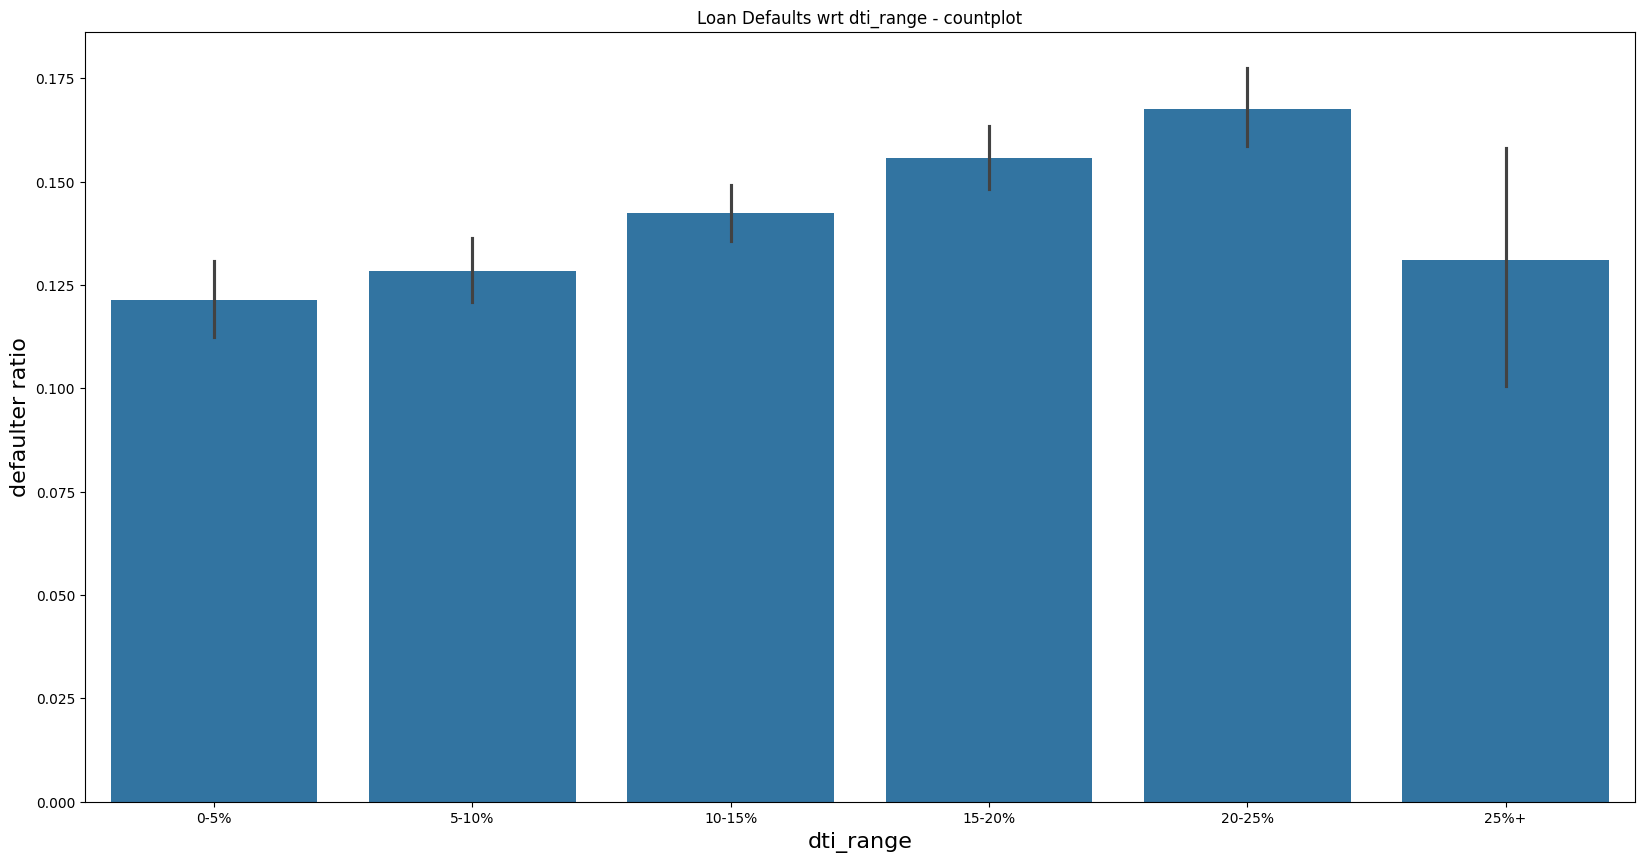

In [257]:
# check for defaulters wrt dti_range in the data using countplot
plotUnivariateBarSegmentedByDefaulter("dti_range")

From above plot for `dti_range` we can infer that the defaulters rate is increasing as with dti_range values, hence rate will depend on dti_range feature.

In [258]:
#get installment value counts
loan["installment_range"].value_counts()

installment_range
medium       17349
low          11705
high          4807
very high     1344
Name: count, dtype: int64

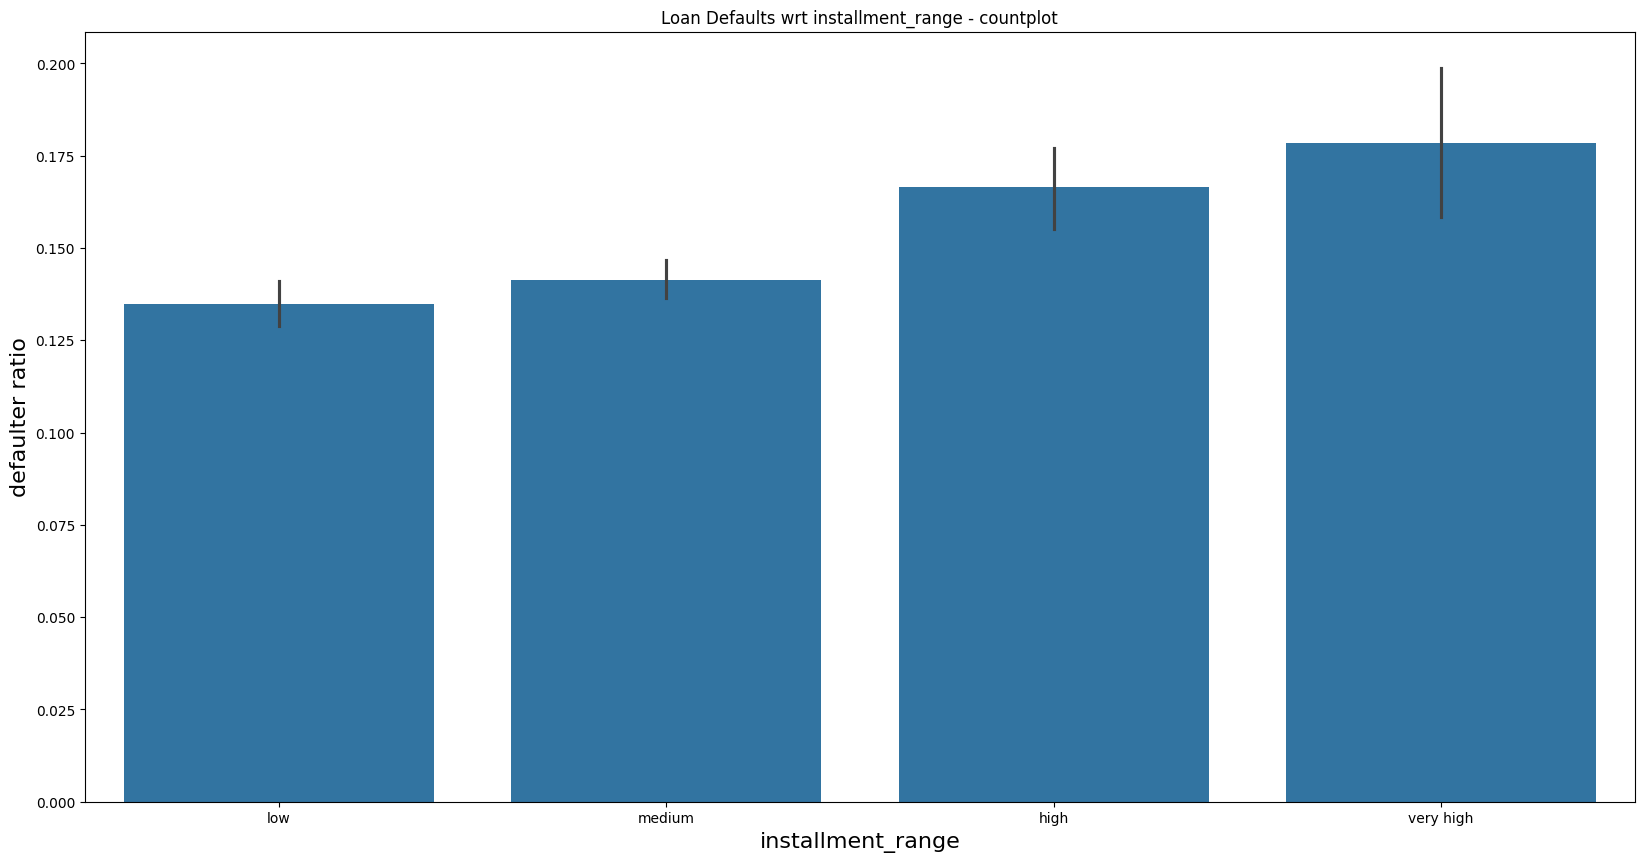

In [259]:
# check for defaulters wrt installment range in the data
plotUnivariateBarSegmentedByDefaulter("installment_range")

From above plot for ‘installment’ we can infer that the defaulters rate is increasing as with installment values, hence rate will depend on dti_range feature.

Therefore, following are the important feature we deduced from above Univariate analysis:

<ul>
<li>term</li>
<li>grade</li>
<li>purpose</li>
<li>pub_rec</li>
<li>pub_rec_bankruptcies</li>
<li>revol_util</li>
<li>funded_amnt_inv</li>
<li>int_rate</li>
<li>annual_inc</li>
<li>dti</li>
<li>installment</li>
</ul>

# 7. Bivariate Analysis

In [260]:
# function to plot scatter plot for two features
def plotScatter(x, y):
    plt.figure(figsize=(16,6))
    sns.scatterplot(x=x, y=y, hue="loan_status", data=loan)
    plt.title("Scatter plot between "+x+" and "+y)
    plt.xlabel(x, fontsize=16)
    plt.ylabel(y, fontsize=16)
    plt.show()
    
def plotBivariateBar(x, hue):
    plt.figure(figsize=(16,6))
    sns.barplot(x=x, y='is_defaulter', hue=hue, data=loan)
    plt.title("Loan Default ratio wrt "+x+" for "+hue+" in the data using countplot")
    plt.xlabel(x, fontsize=16)
    plt.ylabel("defaulter ratio", fontsize=16)
    plt.show()

def plotBivariateHistogram(x, hue):
    plt.figure(figsize=(16,6))
    sns.histplot(x=x, hue=hue, data=loan, multiple='stack', kde=True)
    plt.title("Loan Default ratio wrt "+x+" for "+hue+" in the data using Histogram")
    plt.xlabel(x, fontsize=16)
    plt.ylabel("Frequency", fontsize=16)
    plt.show()


### 7.1 Categorial Data

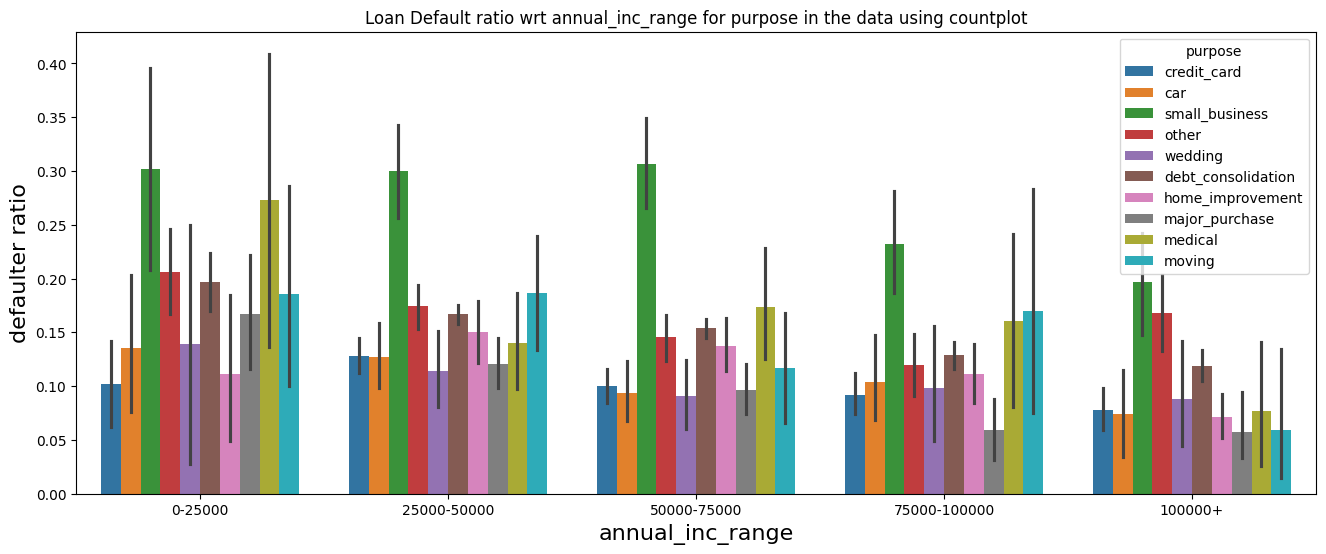

In [261]:
# check for defaulters wrt annual_inc and purpose in the data using countplot
plotBivariateBar("annual_inc_range", "purpose")

From above plot, we can infer it doesn’t shows any correlation

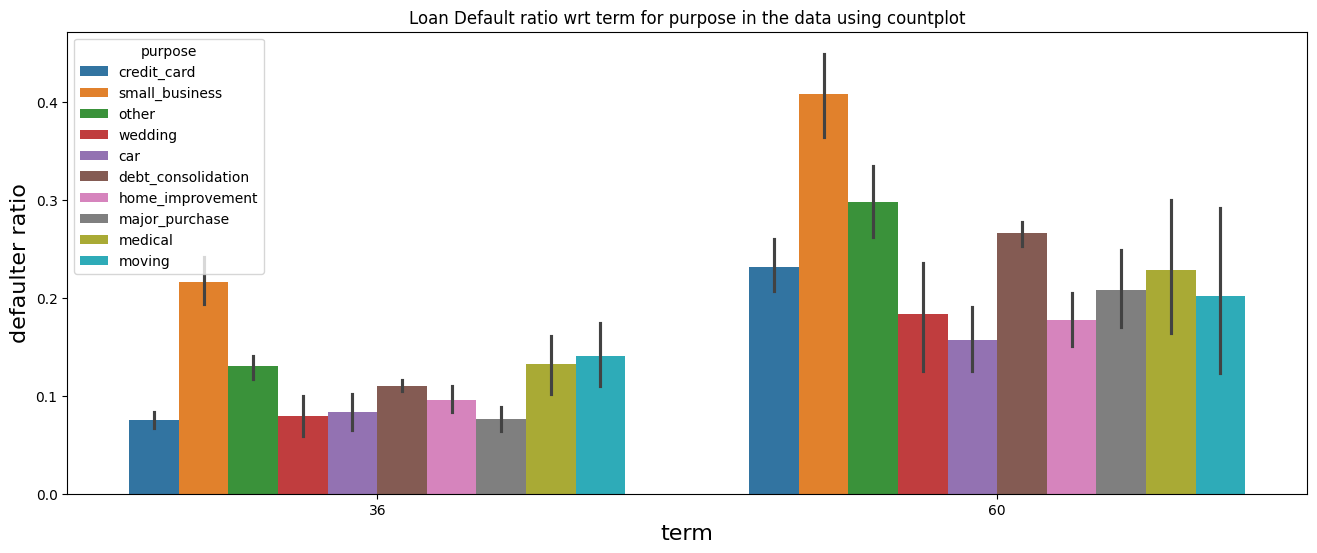

In [262]:
# check for defaulters wrt term and purpose in the data 
plotBivariateBar("term", "purpose")

As we can see , default ratio increases for every purpose wrt term

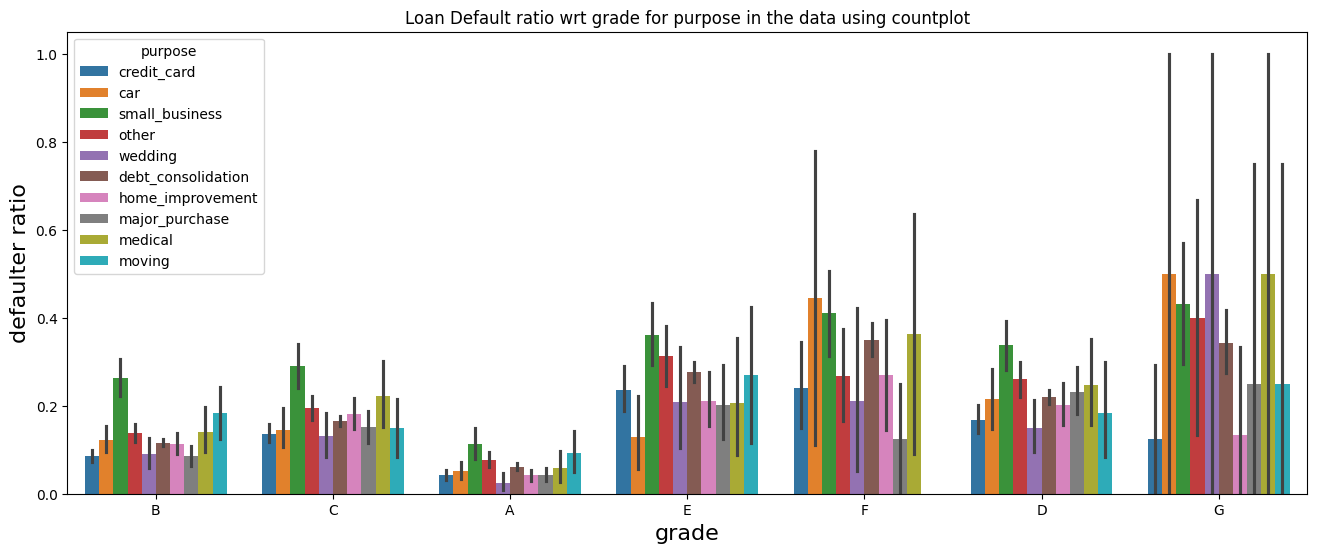

In [263]:
# check for defaulters wrt grade and purpose in the data 
plotBivariateBar("grade", "purpose")

As we can see default ratio increases for every purpose wrt grade

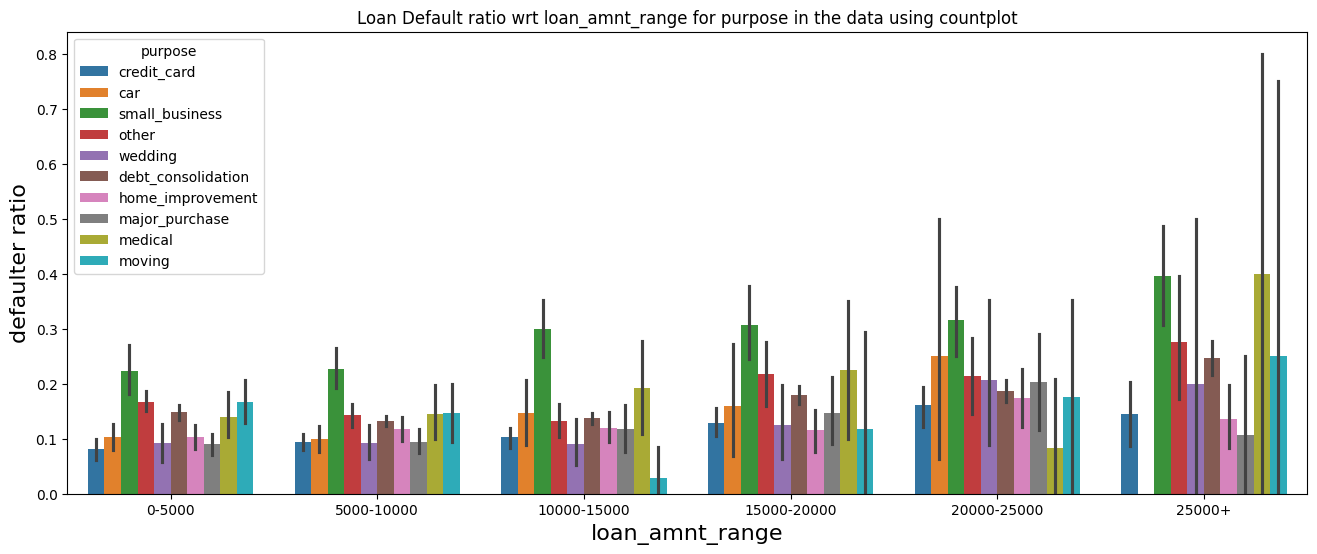

In [264]:
# check for defaulters wrt loan_amnt_range and purpose in the data
plotBivariateBar("loan_amnt_range", "purpose")

As we can see default ratio increases for every purpose wrt loan_amnt_range

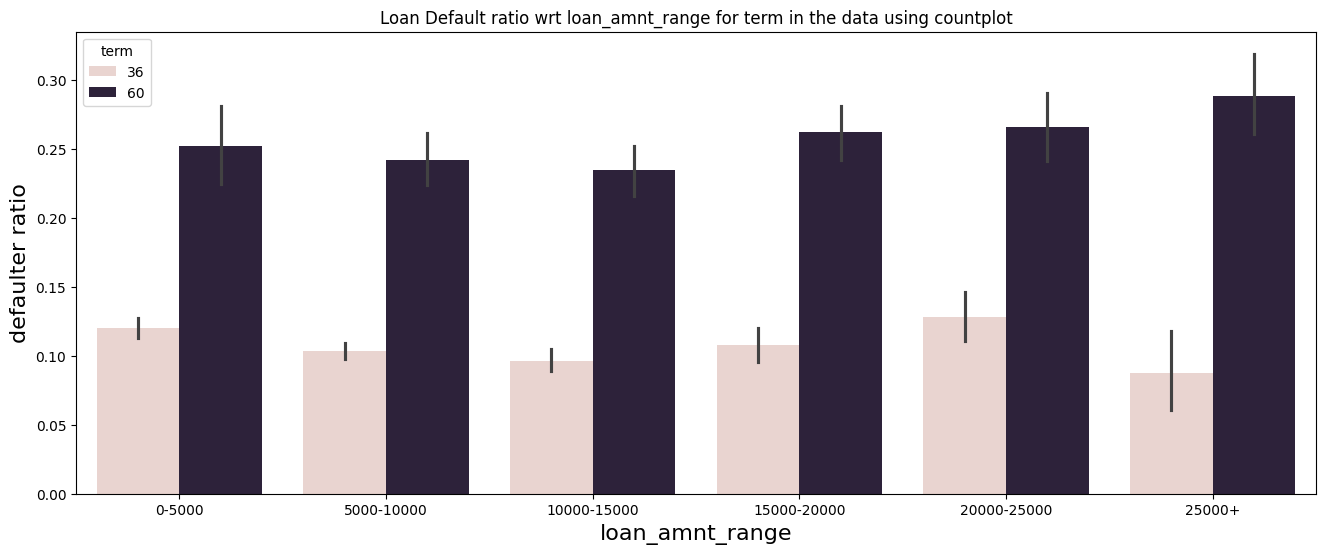

In [265]:
# check for defaulters wrt loan_amnt_range and term in the data
plotBivariateBar("loan_amnt_range", "term")

As we can see as loan amount range increase then default ratio also increases for every term wrt loan_amnt_range

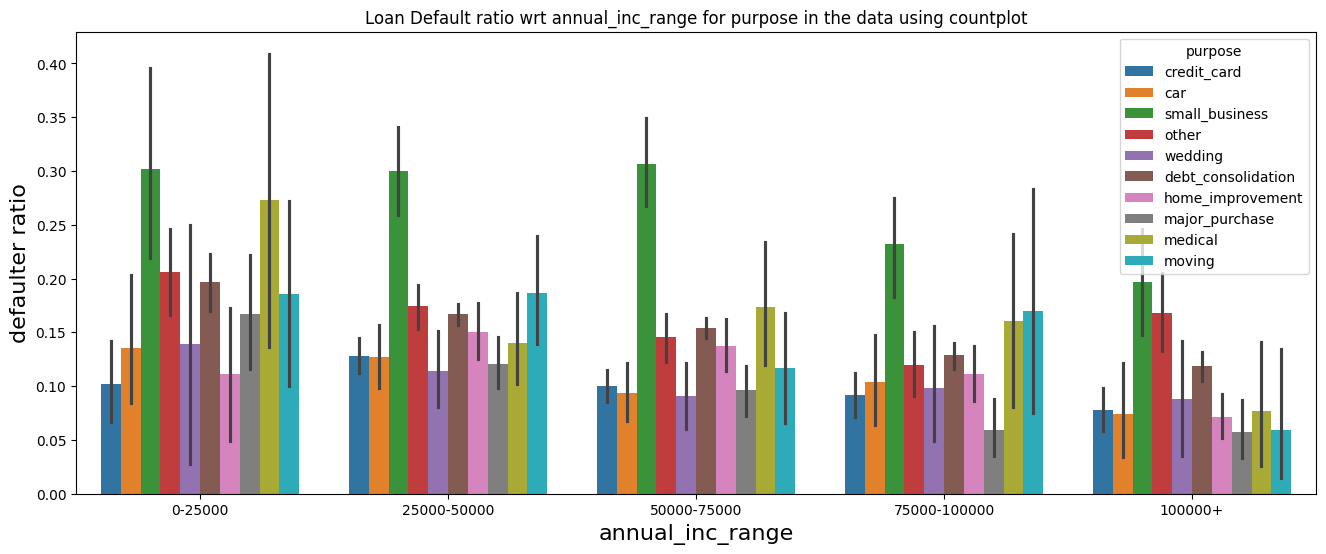

In [266]:
# check for defaulters wrt annual_inc_range and purpose in the data
plotBivariateBar("annual_inc_range", "purpose")

As we can see default ratio increases for every purpose wrt annual_inc_range

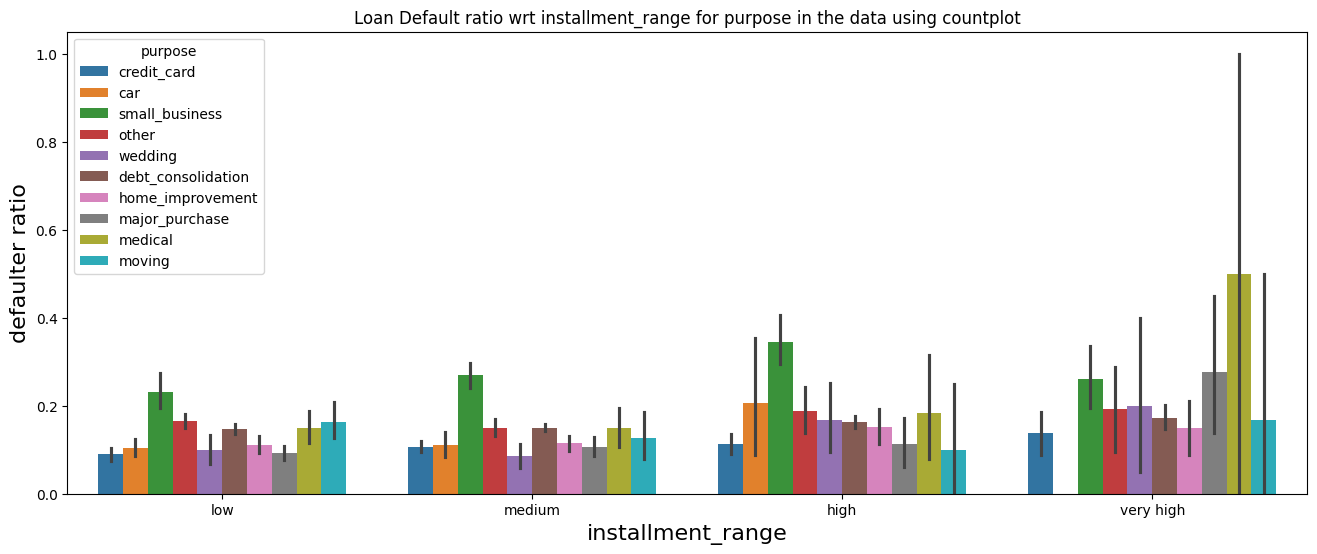

In [267]:
# check for defaulters wrt installment and purpose in the data
plotBivariateBar("installment_range", "purpose")

As we can see  default ratio increases for every purpose wrt installment except for small_business

### 7.2 Continuous Data

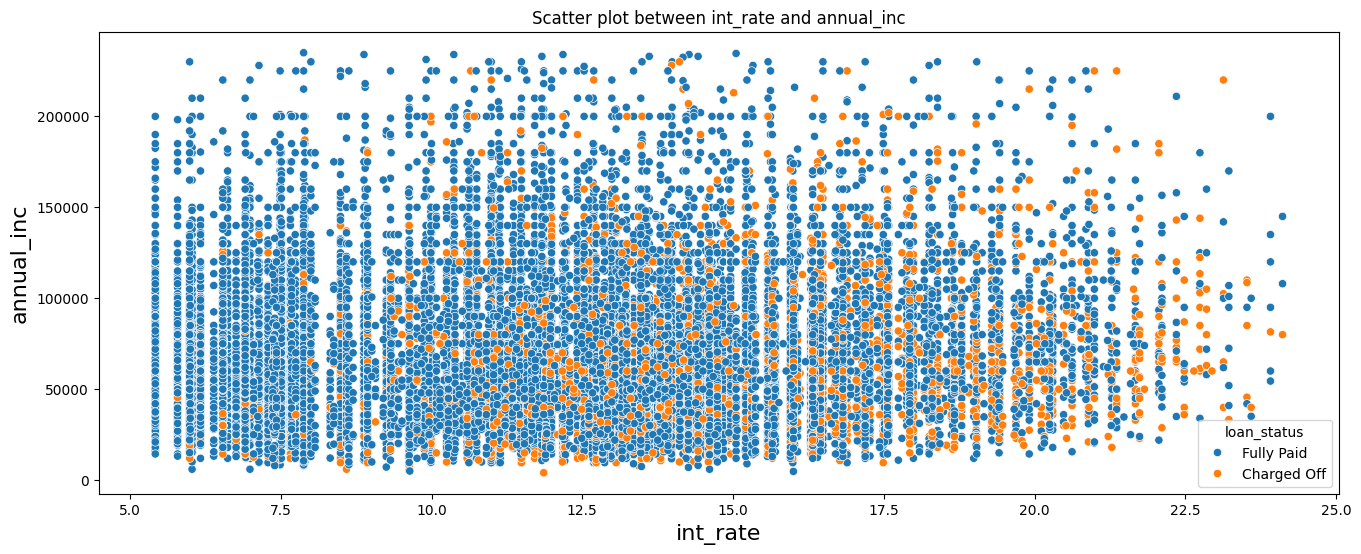

In [268]:
# check for defaulters wrt int_rate and annual_inc in the data
plotScatter("int_rate", "annual_inc")

As we can see straight lines on the plot, there is no relation between above mentioned features

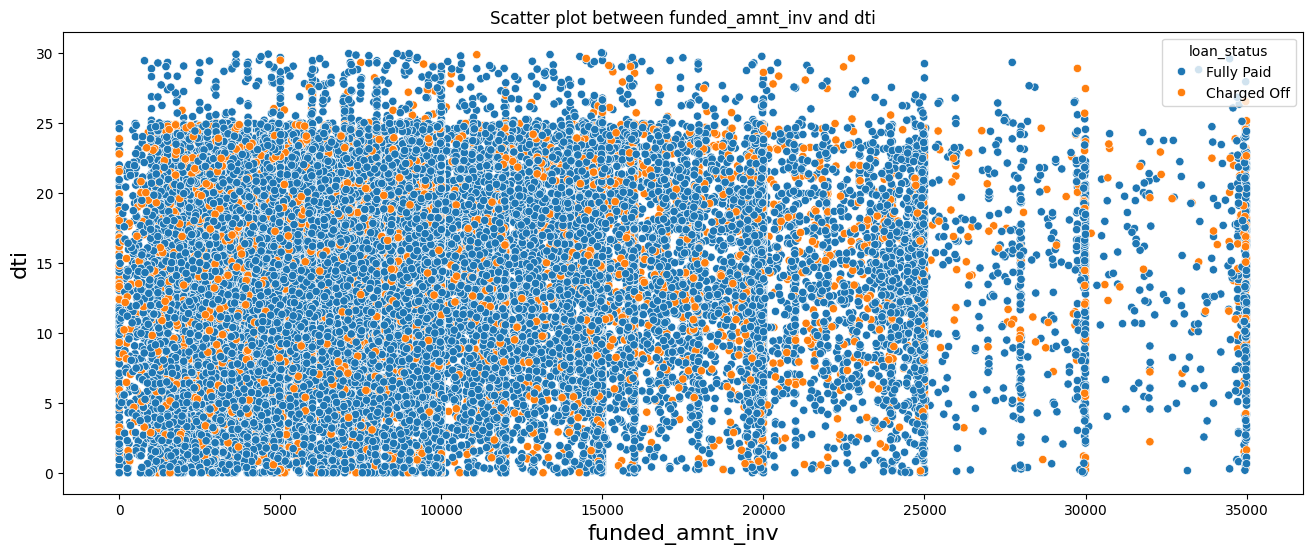

In [269]:
# plot scatter for funded_amnt_inv with dti
plotScatter("funded_amnt_inv", "dti")

As we can see straight lines on the plot, there is no relation between above mentioned features

In [270]:
loan["annual_inc"].value_counts()

annual_inc
60000.00     1380
50000.00      970
40000.00      798
45000.00      756
65000.00      738
             ... 
52769.60        1
120120.00       1
58852.56        1
90696.00        1
27376.00        1
Name: count, Length: 4674, dtype: int64

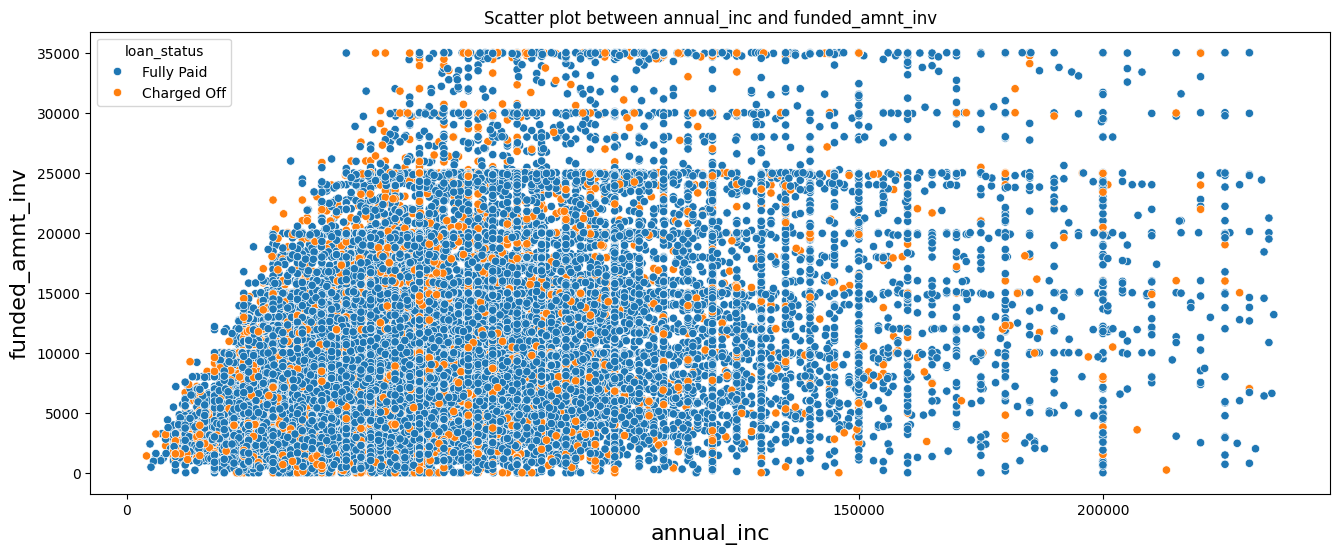

In [271]:
# plot scatter for funded_amnt_inv with annual_inc
plotScatter("annual_inc", "funded_amnt_inv")

As we can see slope pattern on the plot, there is positive relation between above mentioned features

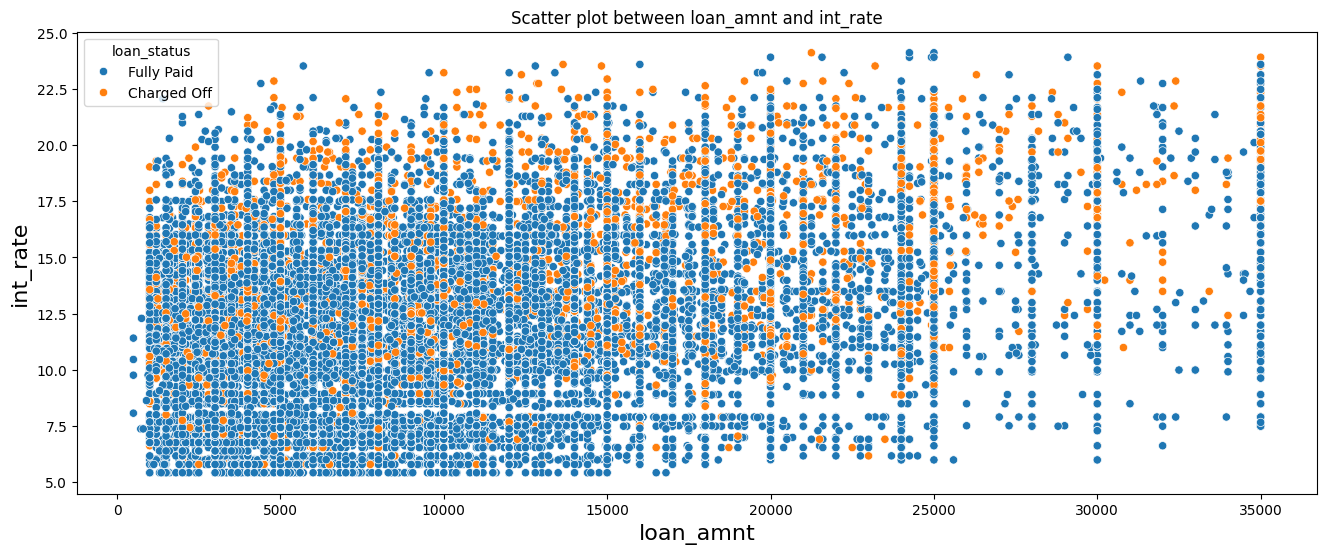

In [272]:
# plot scatter for loan_amnt with int_rate
plotScatter("loan_amnt", "int_rate")

As we can see straight line patterns on the plot, there is no relation between above mentioned features

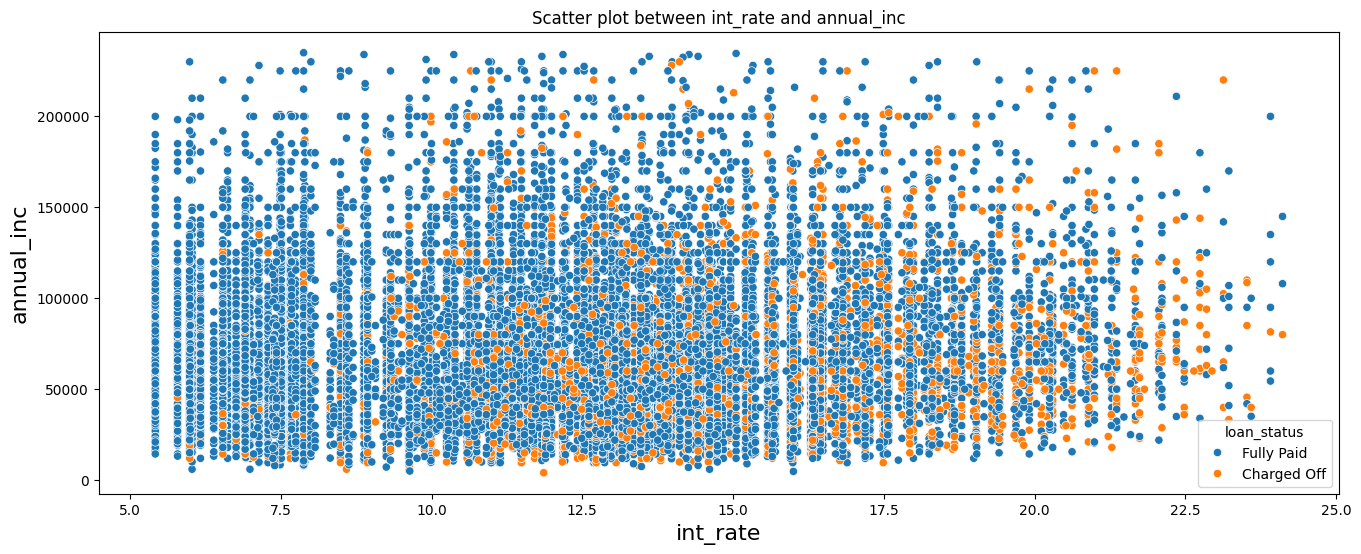

In [273]:
# plot scatter for int_rate with annual_inc
plotScatter("int_rate", "annual_inc")

As we can see negative correlation pattern with reduced density on the plot, there is some relation between above mentioned features

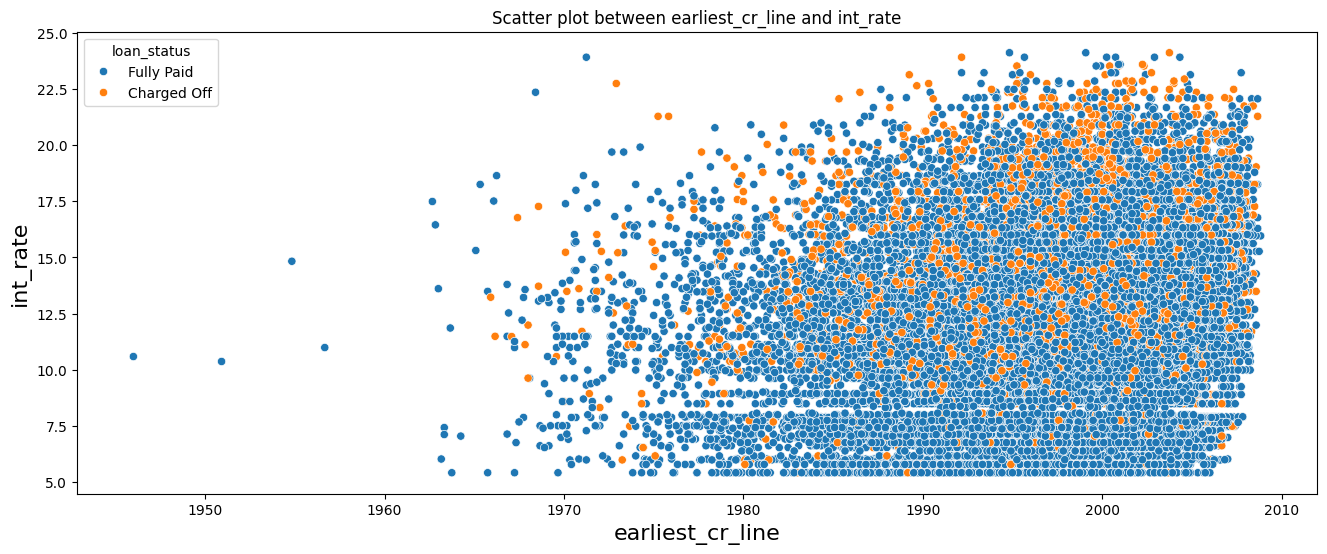

In [274]:
# plot scatter for earliest_cr_line with int_rate
plotScatter("earliest_cr_line", "int_rate")

As we can see positive correlation pattern with increasing density on the plot, there is co-relation between above mentioned features

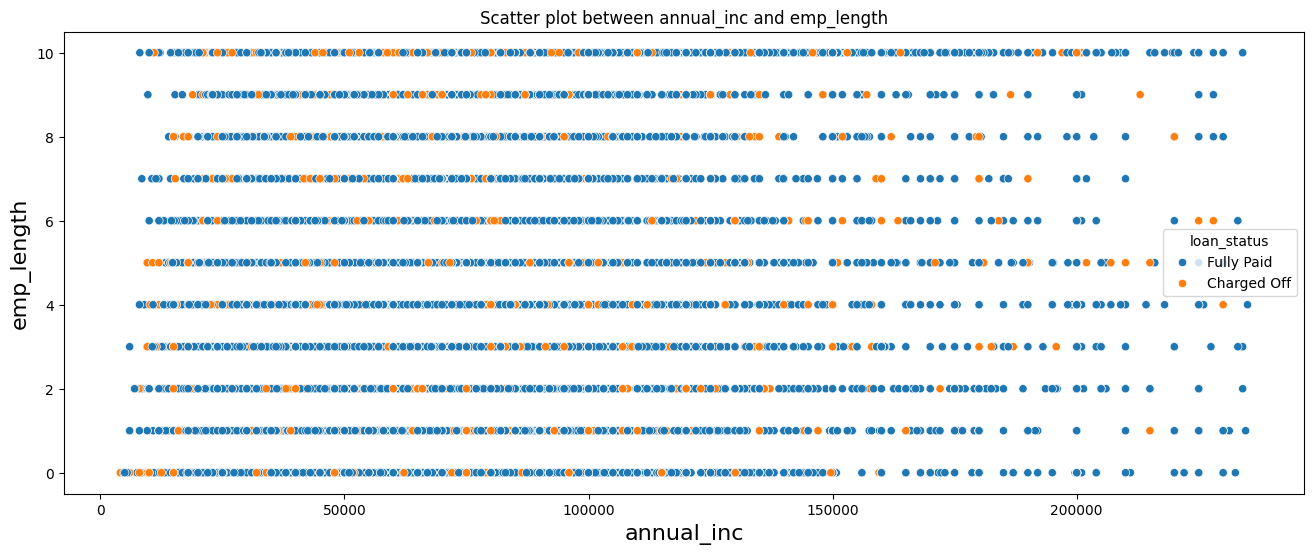

In [275]:
# plot scatter for annual_inc with emp_length
plotScatter("annual_inc", "emp_length")

As we can see straight line patterns on the plot, there is no relation between above mentioned features

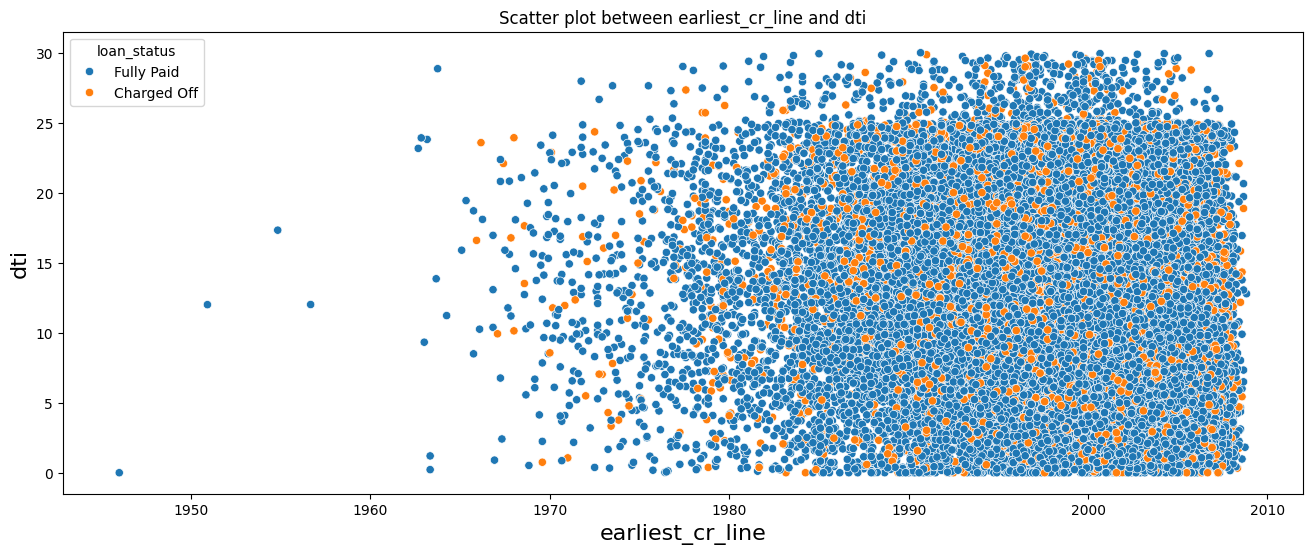

In [276]:
# plot scatter for earliest_cr_line with dti
plotScatter("earliest_cr_line", "dti")

Plotting for two different features with respect to loan default ratio on y-axis with Box Plots.

### 7.3 Categorial vs Continuous Data Types

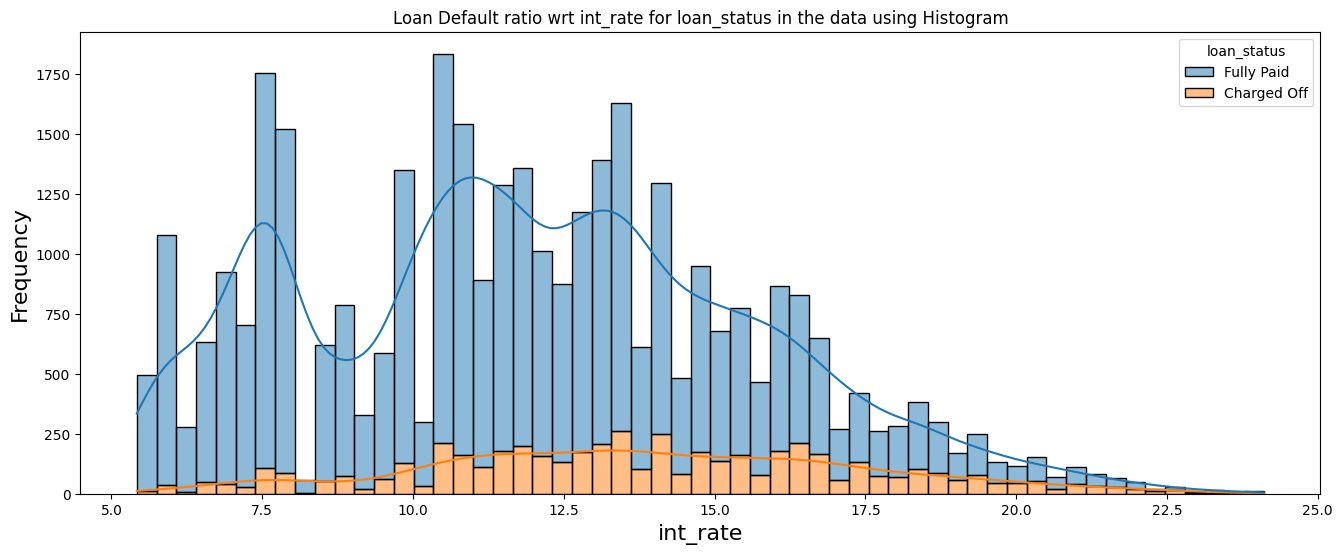

In [277]:
plotBivariateHistogram("int_rate", "loan_status")

In [278]:
# function to plot boxplot for comparing two features
def plotBox(x, y, hue="loan_status"):
    plt.figure(figsize=(16,6))
    sns.boxplot(x=x, y=y, data=loan, hue=hue, order=sorted(loan[x].unique()))
    plt.title("Box plot between "+x+" and "+y+" for each "+hue)
    plt.xlabel(x, fontsize=16)
    plt.ylabel(y, fontsize=16)
    plt.show()
    plt.figure(figsize=(16,8))
    plt.show()

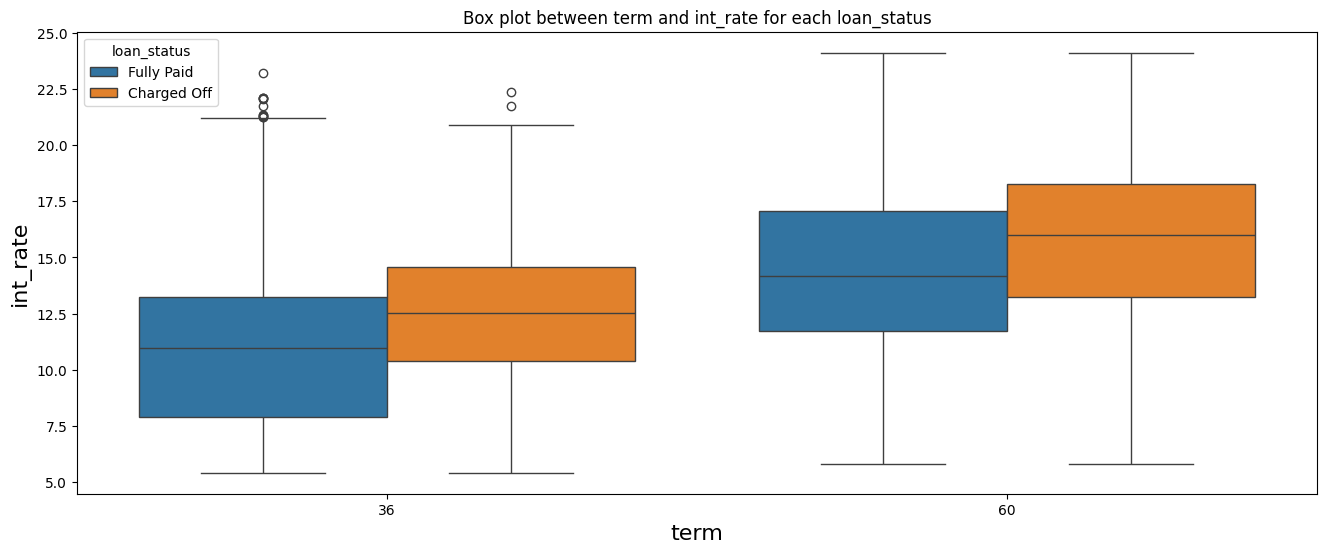

<Figure size 1600x800 with 0 Axes>

In [279]:
# plot box for term vs int_rate for each loan_status
plotBox("term", "int_rate")

int_rate increases with term on loan and the chances of default also increases

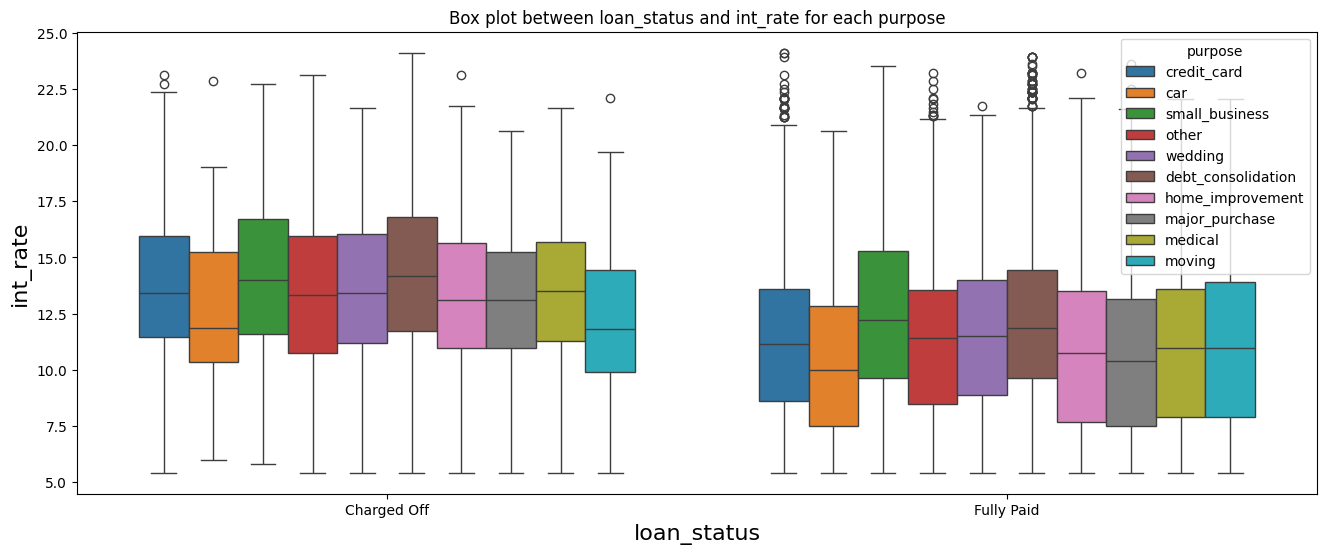

<Figure size 1600x800 with 0 Axes>

In [280]:
# plot box for loan_status vs int_rate for each purpose
plotBox("loan_status", "int_rate", hue="purpose")

int_rate is quite high where the loan is defaulted for every purpose value

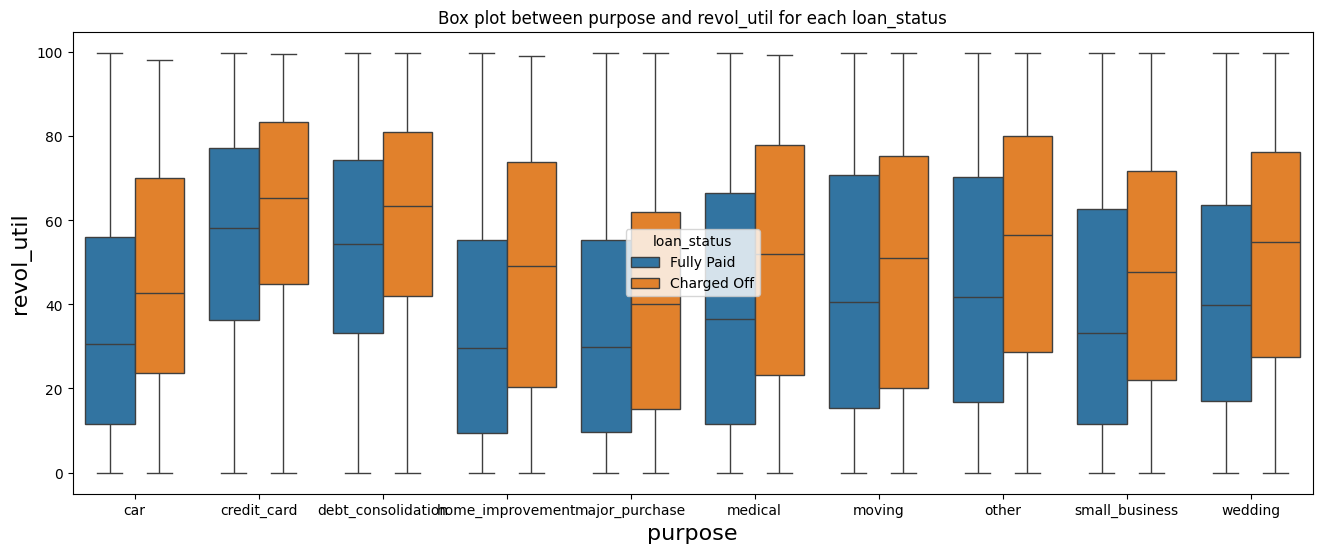

<Figure size 1600x800 with 0 Axes>

In [281]:
# plot box for purpose vs revo_util for each status
plotBox("purpose", "revol_util")

revol_util is more for every purpose value where the loan is defaulted and quite high for credit_card

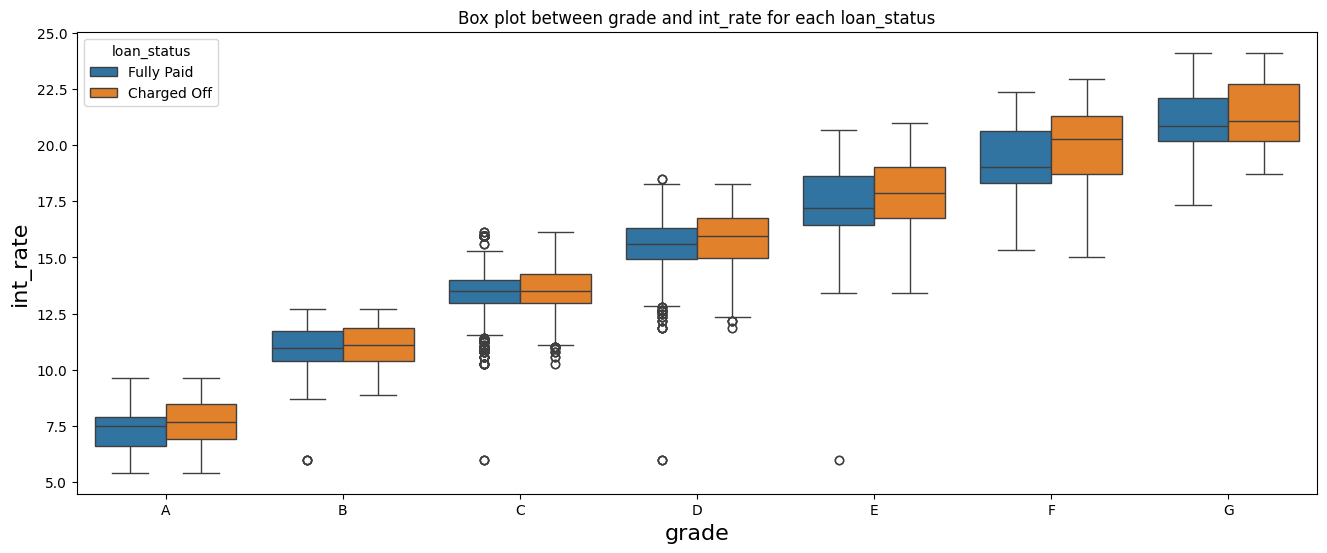

<Figure size 1600x800 with 0 Axes>

In [282]:
# plot box for grade vs int_rate for each loan_status
plotBox("grade", "int_rate", "loan_status")

int_rate is increasing with every grade and also the defaulters for every grade are having their median near the non-defaulter 75% quantile of int_rate

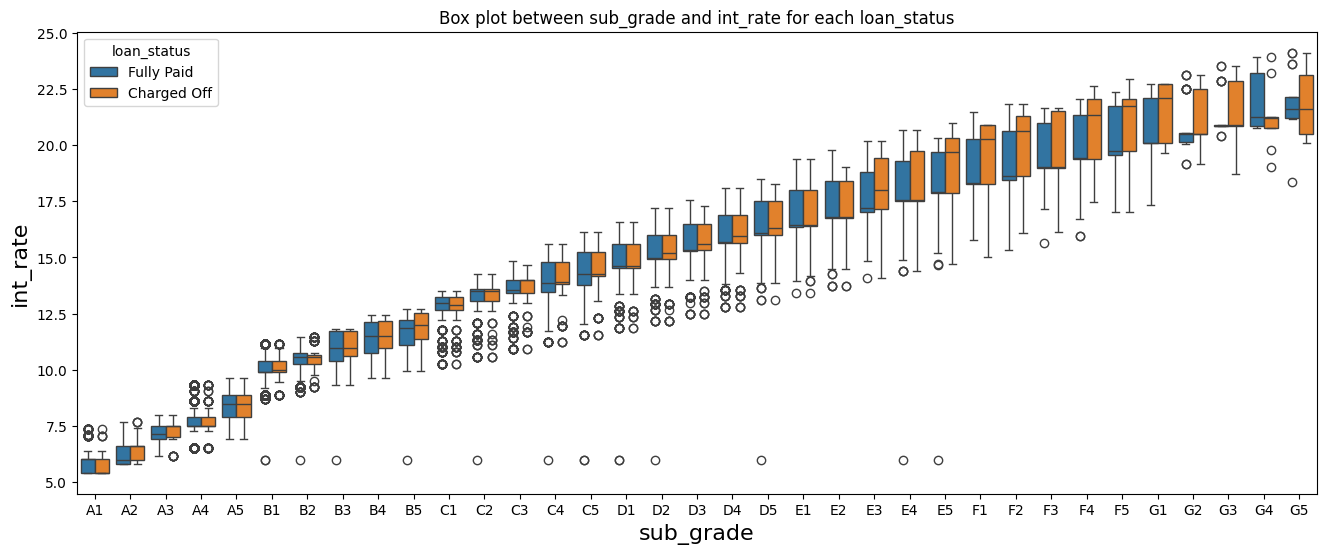

<Figure size 1600x800 with 0 Axes>

In [283]:
# plot box for sub_grade vs int_rate for each loan_status
plotBox("sub_grade", "int_rate", "loan_status")

int_rate is increasing with every sub_grade thus increase likelihood of defaulters.

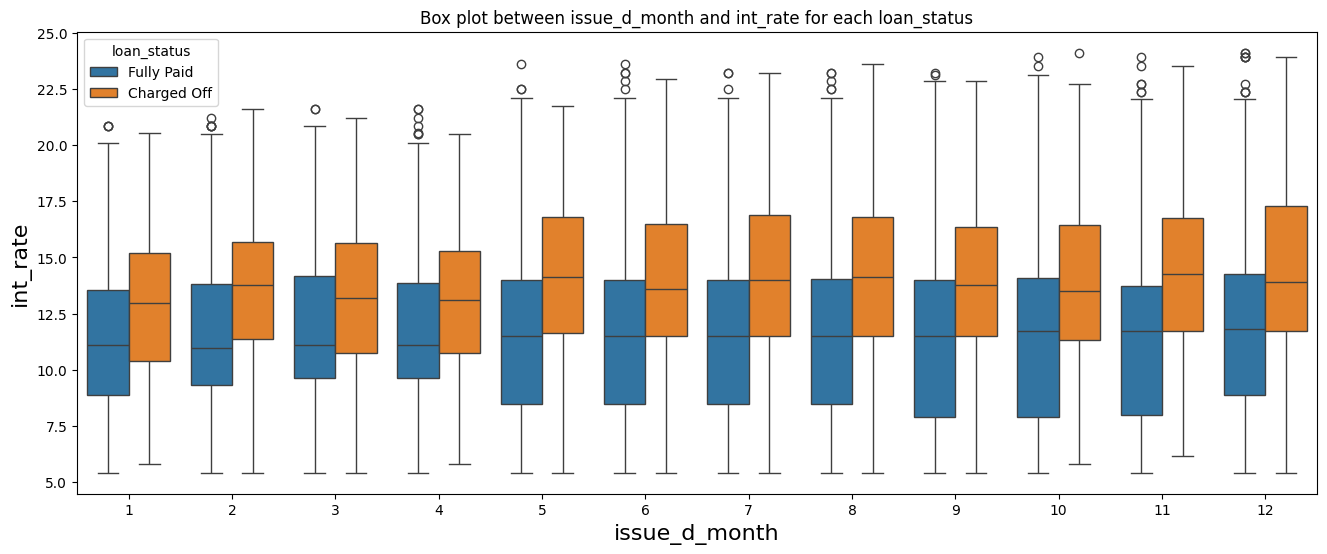

<Figure size 1600x800 with 0 Axes>

In [284]:
# plot box for issue_d vs int_rate for each loan_status
plotBox("issue_d_month", "int_rate")

int_rate for defaulter is increasing with every month where the defaulters for every month are having their median near the non-defaulter’s 75% quantile of int_rate, but is almost constant for each month, hence not useful

Therefore, following are the important feature we deduced from above Bivariate analysis:
<ul>
<li>term
<li>grade
<li>purpose
<li>pub_rec
<li>revol_util
<li>funded_amnt_inv
<li>int_rate
<li>annual_inc
<li>installment
</ul>

# 8 Multivariate Analysis (Correlation)

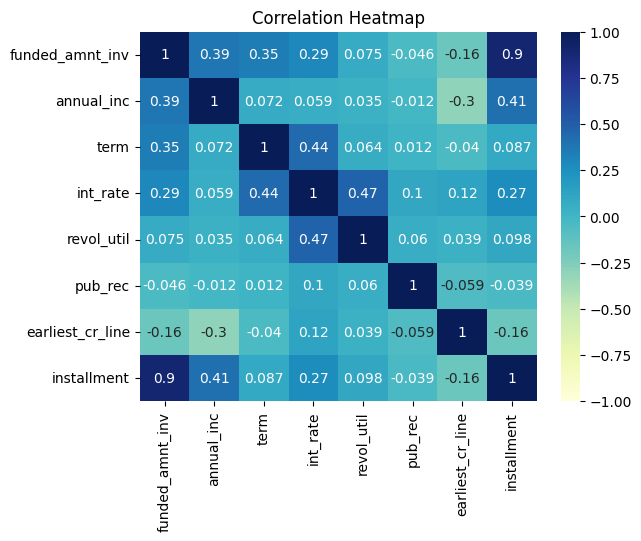

In [285]:
# plot heat map to see correlation between features
continuous_f = ["funded_amnt_inv", "annual_inc", "term", "int_rate", "revol_util", "pub_rec", "earliest_cr_line", "installment"]
loan_corr = loan[continuous_f].corr()
sns.heatmap(loan_corr,vmin=-1.0,vmax=1.0,annot=True, cmap="YlGnBu")
plt.title("Correlation Heatmap")
plt.show()

Hence, important related feature from above Multivariate analysis are:

<ul>
<li>term
<li>grade
<li>purpose
<li>revol_util
<li>int_rate
<li>installment
<li>annual_inc
<li>funded_amnt_inv
</ul>

# 9. Result

The best driving features for the Loan default analysis are: 

<ul>
<li>term
<li>grade
<li>purpose
<li>revol_util
<li>int_rate
<li>installment
<li>annual_inc
<li>funded_amnt_inv
<li>pub_rec
<li>pub_rec_bankruptcies
</ul>